In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Wedge
mpl.rcParams['text.usetex'] = False
import h5py
import numpy as np

import os
import sys

import torch

%config InlineBackend.figure_format = 'retina'

def plot_hist(f, fn):
    fig, axes = plt.subplots(1,3, figsize=(15, 3), sharey=False, sharex=False, tight_layout=False)
    fig.text(0.5, 1.01, f'{fn}', ha='center', fontsize=15)
    axes[0].hist(f['eta_mod'], bins=50, color='skyblue')
    axes[0].set_xlabel('eta_mod')
    axes[0].set_ylabel('Histogram')
    # plt.show()
    axes[1].hist(f['phi_mod'], bins=50, color='magenta')
    axes[1].set_xlabel('phi_mod')
    axes[1].set_ylabel('Histogram')
    # plt.show()
    axes[2].hist(np.log2(f['incident_energy']), density=False, log=True, bins=np.arange(8, 24, 0.5))
    axes[2].set_xlabel('log_2(E)')
    axes[2].set_ylabel('Histogram')
    plt.show()

In [70]:
directory = "/raid/javier/Datasets/CaloVAE/data/ATLAS_2/atlas_regular/"
filenames = os.listdir(directory)
filenames.sort()
print(filenames)
directory + filenames[1]

['dataset_eta_020_positive.hdf5', 'dataset_eta_025_positive.hdf5', 'dataset_eta_030_positive.hdf5', 'dataset_eta_035_positive.hdf5', 'dataset_eta_040_positive.hdf5', 'dataset_eta_045_positive.hdf5', 'dataset_eta_050_positive.hdf5', 'dataset_eta_055_positive.hdf5', 'dataset_eta_060_positive.hdf5', 'dataset_eta_065_positive.hdf5', 'dataset_eta_070_positive.hdf5', 'dataset_eta_085_positive.hdf5', 'dataset_eta_090_positive.hdf5', 'dataset_eta_095_positive.hdf5']


'/raid/javier/Datasets/CaloVAE/data/ATLAS_2/atlas_regular/dataset_eta_025_positive.hdf5'

dataset_eta_025_positive.hdf5
torch.Size([127271, 336])


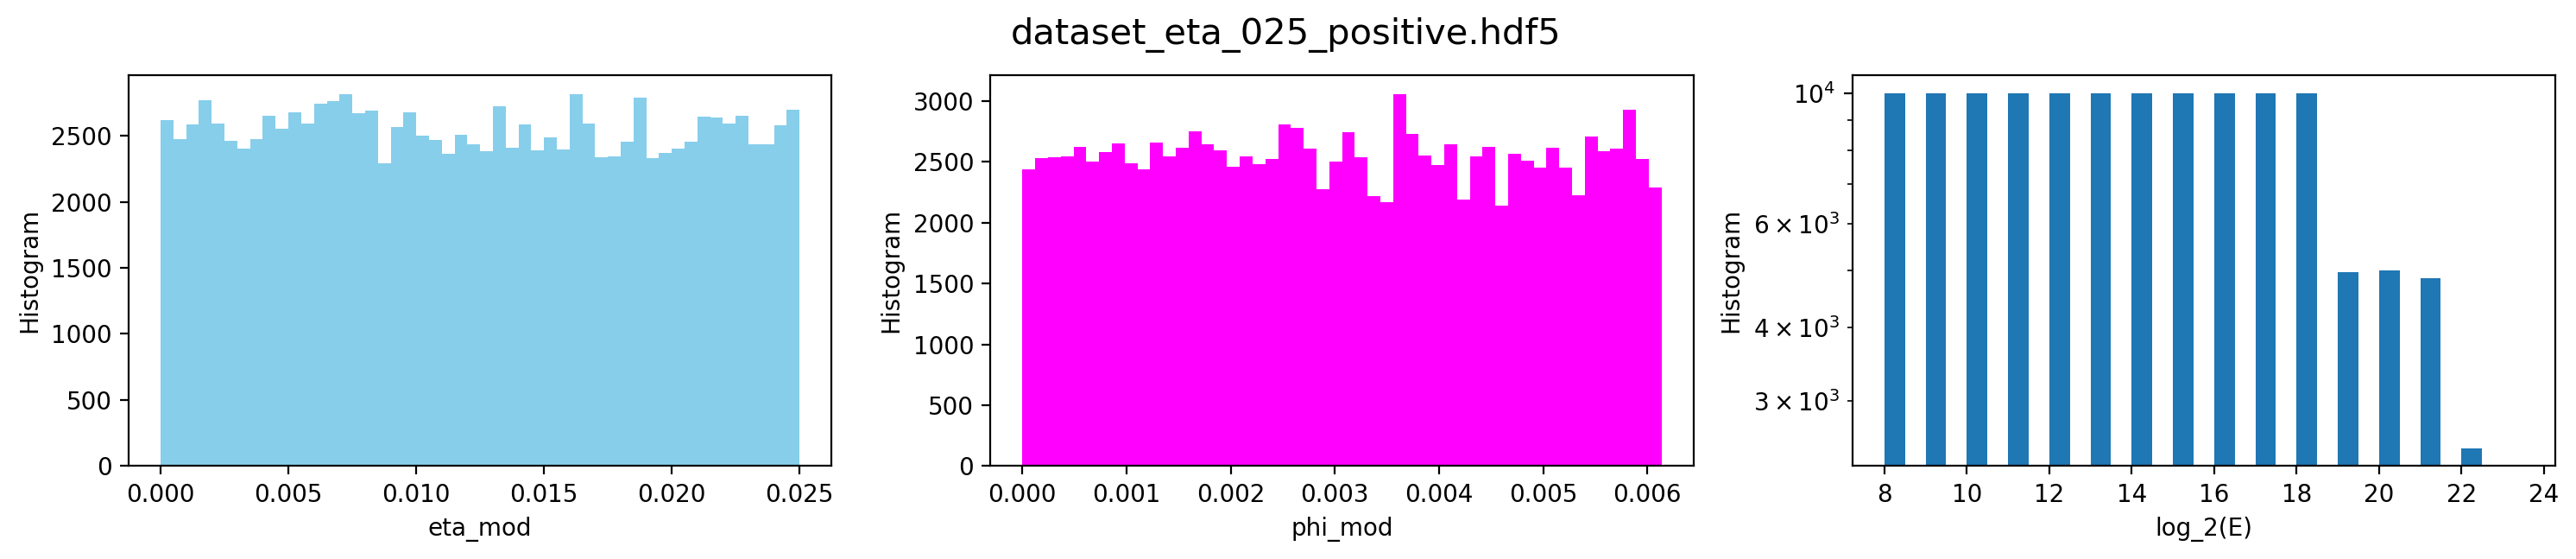

In [72]:


# ATLAS_raw_dir = '/raid/javier/Datasets/CaloVAE/data/ATLAS/dataset_eta_020_positive.hdf5'
# for fn in filenames:
print(fn)
ATLAS_raw_dir = directory + fn #filenames[-2]
with h5py.File(ATLAS_raw_dir, 'r') as file:
    # List all groups
    f = {}
    # print("Keys: %s" % list(file.keys()))
    for key in file.keys():
        f[key] = torch.tensor(np.array(file[key]))
print(f["energy_layer_1"].shape)
plot_hist(f,fn)


In [74]:

336/14

24.0

In [73]:
# np.unique(f[f'binstart_radius_layer_0'])
s = 0
for i in range(4):
    print(f[f'binstart_radius_layer_{i}'].shape)
    s = s + f[f'binstart_radius_layer_{i}'].shape[0]
print(s)

s = 0
for i in [0,1,2,3,12,13]:
    print(f[f'binstart_radius_layer_{i}'].shape)
    s = s + f[f'binstart_radius_layer_{i}'].shape[0]
print(s)

torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
1344
torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
2016


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def add_cylindrical_voxel(ax, r_in, r_out, theta0, theta1, z_low, z_high, num_points=20, color=None):
    """
    Adds a single cylindrical voxel (wedge) to the 3D axis.
    
    Parameters:
      ax       : Matplotlib 3D axis.
      r_in     : Inner radius.
      r_out    : Outer radius.
      theta0   : Starting angle in radians.
      theta1   : Ending angle in radians.
      z_low    : Lower z-bound.
      z_high   : Upper z-bound.
      num_points: Number of points along the arc.
      color    : Color to fill the voxel.
    """
    # Generate a smooth arc between theta0 and theta1.
    theta = np.linspace(theta0, theta1, num_points)
    
    # Top face arcs
    outer_top = np.column_stack((r_out * np.cos(theta), r_out * np.sin(theta), np.full(theta.shape, z_high)))
    inner_top = np.column_stack((r_in * np.cos(theta), r_in * np.sin(theta), np.full(theta.shape, z_high)))
    
    # Bottom face arcs
    outer_bot = np.column_stack((r_out * np.cos(theta), r_out * np.sin(theta), np.full(theta.shape, z_low)))
    inner_bot = np.column_stack((r_in * np.cos(theta), r_in * np.sin(theta), np.full(theta.shape, z_low)))
    
    # Build top and bottom faces (by joining outer and inner arcs)
    top_face = np.concatenate((outer_top, inner_top[::-1]))
    bottom_face = np.concatenate((outer_bot, inner_bot[::-1]))
    
    # Create side faces at the angular boundaries (using first and last points)
    side_face_start = np.array([outer_bot[0], outer_top[0], inner_top[0], inner_bot[0]])
    side_face_end   = np.array([outer_bot[-1], outer_top[-1], inner_top[-1], inner_bot[-1]])
    
    faces = [top_face, bottom_face, side_face_start, side_face_end]
    
    poly3d = Poly3DCollection(faces, alpha=0.6, edgecolor='k', facecolor=color)
    ax.add_collection3d(poly3d)

def add_layer_varying(ax, radii, thetas, z_low, z_high, num_points=20, color=None):
    """
    Constructs one layer of the cylinder when the angular partitions vary by ring.
    
    The radii and theta arrays are 1D with repeated values. We group them
    and, for each annular cell between unique radii[i] and unique radii[i+1],
    we use the theta boundaries from the outer ring (group i+1). This function
    also adds a closing wedge to complete the circle.
    
    Parameters:
      ax     : The matplotlib 3D axis.
      radii  : 1D array of radii boundaries (with repeats).
      thetas : 1D array of theta boundaries (with repeats).
      z_low  : Lower z-bound for this layer.
      z_high : Upper z-bound for this layer.
      color  : Color for this layer.
    """
    unique_radii, r_counts = np.unique(radii, return_counts=True)
    
    # Split the theta array into groups using the counts from radii.
    theta_groups = []
    idx = 0
    for count in r_counts:
        theta_groups.append(thetas[idx:idx+count])
        idx += count

    # Loop over annular cells.
    for i in range(len(unique_radii) - 1):
        r_in = unique_radii[i]
        r_out = unique_radii[i+1]
        # Choose theta boundaries from the outer ring (group i+1).
        if i+1 < len(theta_groups):
            theta_boundaries = theta_groups[i+1]
        else:
            theta_boundaries = theta_groups[-1]
            
        # Create wedges for each angular segment.
        for j in range(len(theta_boundaries) - 1):
            theta0 = theta_boundaries[j]
            theta1 = theta_boundaries[j+1]
            add_cylindrical_voxel(ax, r_in, r_out, theta0, theta1, z_low, z_high, num_points, color)
        
        # --- Add the closing wedge ---
        theta0 = theta_boundaries[-1]
        theta1 = theta_boundaries[0] + 2 * np.pi
        add_cylindrical_voxel(ax, r_in, r_out, theta0, theta1, z_low, z_high, num_points, color)


/tmp/ipykernel_3364274/3054673983.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("viridis")


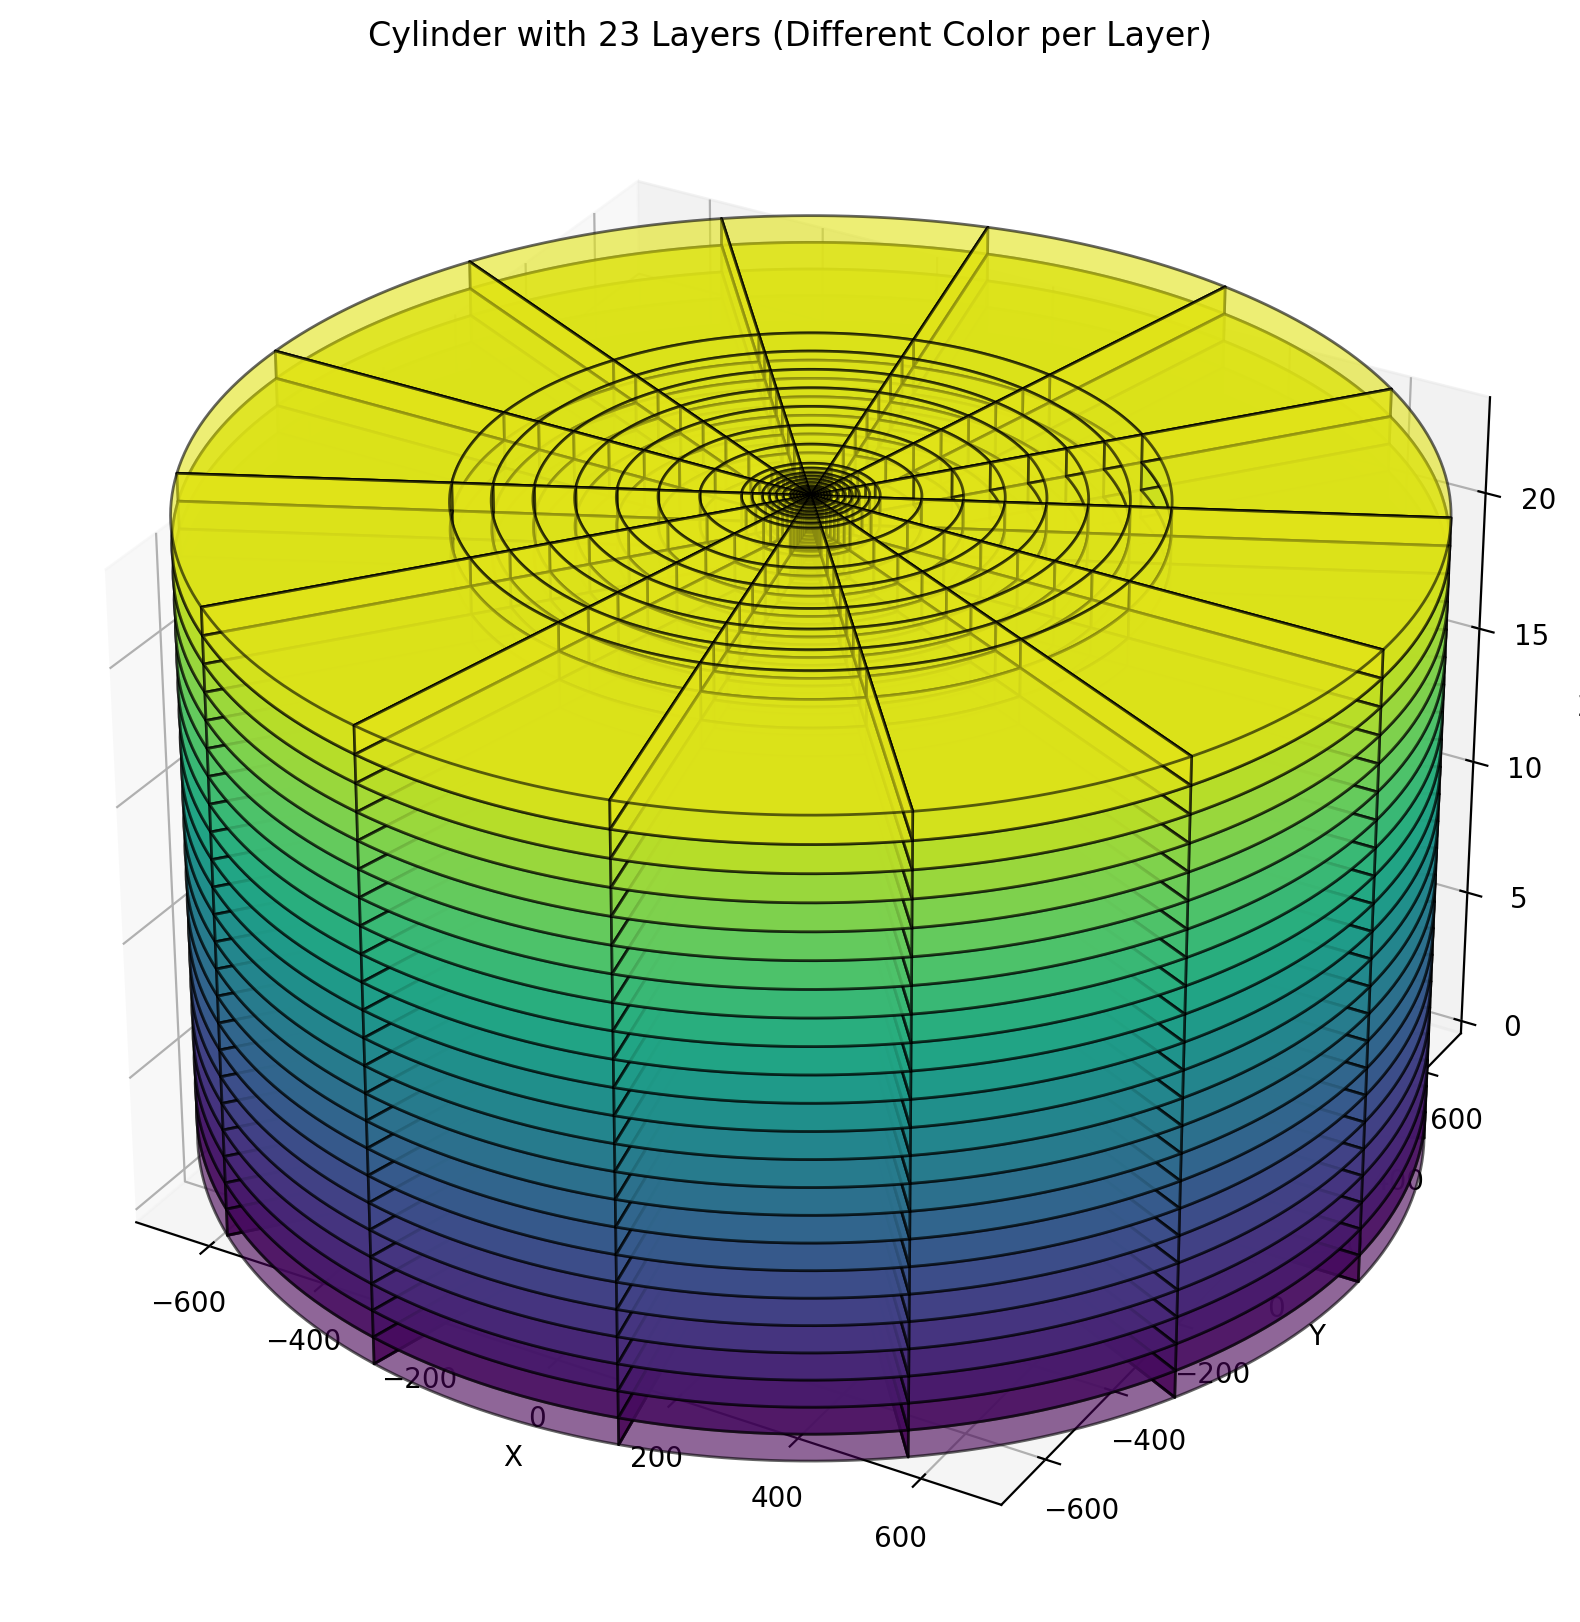

In [59]:
# --- Example usage ---
# For this example, we assume the theta array is complete and each group’s length matches 
# the repetition count for the corresponding unique radius in the radii array.
# (In your actual data you might need to verify or adjust the grouping.)

# Set up the 3D plot.
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

num_layers = 23
layer_thickness = 1.0  # Adjust vertical spacing as needed

colormap = cm.get_cmap("viridis")

for layer in range(num_layers):
    z_low = layer * layer_thickness
    z_high = (layer + 1) * layer_thickness
    # Get a color from the colormap based on the layer index.
    color = colormap(layer / num_layers)
    add_layer_varying(ax, f[f'binstart_radius_layer_{layer}'], f[f'binstart_alpha_layer_{layer}'], z_low, z_high, num_points=20, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-700, 700)
ax.set_ylim(-700, 700)
ax.set_zlim(0, num_layers * layer_thickness)
plt.title("Cylinder with 23 Layers (Different Color per Layer)")
plt.show()

In [60]:
class PLT_ATLAS:
    def __init__(self, raw_dir, event_n, all_layers=None):
        """
        Initialize the PLT_ATLAS object.

        Parameters:
        - raw_dir: Path to the raw HDF5 data file.
        - event_n: Event number to process.
        - all_layers: List of layer numbers to plot. Defaults to [0, 1, 2, 3, 12].
        """
        if all_layers is None:
            all_layers = [i for i in range(24)]#[0, 1, 2, 3, 12]
        self.ATLAS_raw_dir = raw_dir
        # self.data = h5py.File(self.ATLAS_raw_dir, 'r')
        self.load_dataset()
        self.event_n = event_n
        self.all_layers = all_layers
        
    def load_dataset(self):
        with h5py.File(ATLAS_raw_dir, 'r') as file:
            # List all groups
            self.data = {}
            print("Keys: %s" % list(file.keys()))
            for key in file.keys():
                self.data[key] = torch.tensor(np.array(file[key]))
        # with h5py.File(self.ATLAS_raw_dir, 'r') as file:
        #     # List all groups
        #     self.data = {}
        #     print("Keys: %s" % list(file.keys()))
        #     for key in file.keys():
        #         self.data[key] = torch.tensor(file[key])

    def get_section_info(self):
        """
        Process and retrieve sector information for plotting.

        Returns:
        - List of tuples containing (inner_r, outer_r, start_angle, end_angle, energy).
        """
        # Convert angles from radians to degrees and round
        binstart_alpha_deg = torch.round(self.binstart_alpha_info / torch.pi * 180)
        binend_alpha_deg = binstart_alpha_deg + torch.round(self.binsize_alpha_info / torch.pi * 180)
        
        # Calculate end radius
        binend_radius_info = self.binstart_radius_info + self.binsize_radius_info
        
        # Combine all sector information into a list of tuples
        sectors = list(zip(
            self.binstart_radius_info.tolist(),
            binend_radius_info.tolist(),
            binstart_alpha_deg.tolist(),
            binend_alpha_deg.tolist(),
            self.single_event_energy.tolist()
        ))
        return sectors

    def plot_calorimeter(self, ax, scale='equal_bin', cmap=cm.rainbow, norm=None, title=None):
        """
        Plot the Calorimeter Layer Energy Diagram on a given axis.

        Parameters:
        - ax: Matplotlib axis to plot on.
        - scale: 'linear' or 'equal_bin', determines the type of radial scale.
        - cmap: Colormap for the energy representation.
        - norm: Normalization for the colormap.
        - title: Title for the subplot.
        """
        sectors = self.sectors

        # If normalization is not provided, create it based on current energies
        if norm is None:
            energies = [sector[4] for sector in sectors]
            norm = LogNorm(vmin=max(min(values), 0.0001), vmax=max(max(values), 0.0001))

        if scale == 'linear':
            # Linear radial scale
            max_radius = max(sector[1] for sector in sectors)
            transform = lambda r: r
        elif scale == 'equal_bin':
            # Equal bin radial scale
            radial_boundaries = sorted({r for sector in sectors for r in (sector[0], sector[1])})
            num_layers = len(radial_boundaries) - 1
            plot_radial_boundaries = np.linspace(0, 1, num_layers + 1)

            def transform(r):
                """
                Map actual radius to plot radius ensuring equal space for each layer.
                """
                for i in range(num_layers):
                    if radial_boundaries[i] <= r < radial_boundaries[i + 1]:
                        layer_fraction = (r - radial_boundaries[i]) / (radial_boundaries[i + 1] - radial_boundaries[i])
                        return plot_radial_boundaries[i] + layer_fraction * (plot_radial_boundaries[i + 1] - plot_radial_boundaries[i])
                return plot_radial_boundaries[-1]  # Handle the maximum boundary

            max_radius = plot_radial_boundaries[-1]
        else:
            raise ValueError("The 'scale' parameter must be 'linear' or 'equal_bin'")

        # Plot each sector as a wedge
        for inner_r, outer_r, start_angle, end_angle, energy in sectors:
            color = cmap(norm(energy))
            if scale == 'equal_bin':
                transformed_inner = transform(inner_r)
                transformed_outer = transform(outer_r)
                width = transformed_outer - transformed_inner
                wedge = Wedge(
                    center=(0, 0),
                    r=transformed_outer,
                    theta1=start_angle,
                    theta2=end_angle,
                    width=width,
                    edgecolor='black',
                    facecolor=color,
                    alpha=1
                )
            else:  # 'linear'
                wedge = Wedge(
                    center=(0, 0),
                    r=transform(outer_r),
                    theta1=start_angle,
                    theta2=end_angle,
                    width=transform(outer_r) - transform(inner_r),
                    edgecolor='black',
                    facecolor=color,
                    alpha=1
                )
            try:
                ax.add_patch(wedge)
            except:
                pass

        # Configure plot limits and appearance
        ax.set_xlim(-max_radius - 0.1, max_radius + 0.1)
        ax.set_ylim(-max_radius - 0.1, max_radius + 0.1)
        ax.set_aspect('equal')
        ax.axis('off')

        # Add title if provided
        if title:
            ax.set_title(title, fontsize=15)

    def plot_all_layers(self, event_n, scale='equal_bin', vmin=1e-2, vmax=1e4):
        """
        Plot all specified layers of the calorimeter for the given event in a composite figure.

        Parameters:
        - scale: 'linear' or 'equal_bin', determines the type of radial scale for all subplots.
        """
        self.event_n = event_n
        num_layers = len(self.all_layers)
        # Create a figure with subplots arranged in one row
        figsize = (15, 15)
        fig = plt.figure(figsize=figsize, dpi=200)
        # fig, axes = plt.subplots(4, 5, figsize=(6 * num_layers, 7), constrained_layout=True) # figsize=(6 * num_layers, 7)
        
        
        # Ensure axes is iterable
        if num_layers == 1:
            axes = [axes]

        # Initialize variables to determine global normalization across all layers
        all_energies = []

        # First pass: Collect all energies to set a common normalization

        # Define global normalization
        norm = LogNorm(vmin=vmin, vmax=vmax)
        incident_energy = torch.tensor(self.data["incident_energy"][self.event_n])
        # Iterate through each layer and plot on the corresponding axis
        for i, layer in enumerate(self.all_layers):
            # Retrieve and process data for the current layer
            # energy_info = torch.tensor(self.data[f'energy_layer_{layer}'][self.event_n, :])
            # binsize_alpha = torch.tensor(self.data[f"binsize_alpha_layer_{layer}"][:])
            # binstart_alpha = torch.tensor(self.data[f"binstart_alpha_layer_{layer}"][:])
            # binsize_radius = torch.tensor(self.data[f"binsize_radius_layer_{layer}"][:])
            # binstart_radius = torch.tensor(self.data[f"binstart_radius_layer_{layer}"][:])
            energy_info = self.data[f'energy_layer_{layer}'][self.event_n, :]
            binsize_alpha = self.data[f"binsize_alpha_layer_{layer}"]
            binstart_alpha = self.data[f"binstart_alpha_layer_{layer}"]
            binsize_radius = self.data[f"binsize_radius_layer_{layer}"]
            binstart_radius = self.data[f"binstart_radius_layer_{layer}"]
            single_event_energy = energy_info * incident_energy

            # Assign data to instance variables for section info retrieval
            self.binsize_alpha_info = binsize_alpha
            self.binstart_alpha_info = binstart_alpha
            self.binsize_radius_info = binsize_radius
            self.binstart_radius_info = binstart_radius
            self.single_event_energy = single_event_energy

            # Get sector information
            self.sectors = self.get_section_info()

            # Plot on the provided axis with a common normalization
            ax = plt.subplot(5, 5, i+1)
            self.plot_calorimeter(ax=ax, scale=scale, norm=norm, title=f'Layer {layer}')

        # Add a single colorbar for all subplots
        # Positioning the colorbar to the right of all subplots
        fig.suptitle(f'Calorimeter Layer Energy Diagram when E = {incident_energy/1000:.2f} GeV\n', fontsize=15)
        cbar_ax = fig.add_axes([0.05, -0.1, 0.9, 0.1])  # [left, bottom, width, height]
        cmap = 'rainbow' #cm.viridis
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, location='bottom', orientation='horizontal')
        cbar.set_label('Energy in MeV', fontsize=15)
        cbar.ax.tick_params(labelsize=20)  # 设置刻度标签字体大小为12

        plt.show()

In [19]:
# plot_atlas = PLT_ATLAS(ATLAS_raw_dir,117270).plot_all_layers(scale='linear',vmin=1e-2, vmax=1e3)

In [61]:
plot_atlas = PLT_ATLAS(ATLAS_raw_dir,125000)

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

/tmp/ipykernel_3364274/4237646877.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  incident_energy = torch.tensor(self.data["incident_energy"][self.event_n])


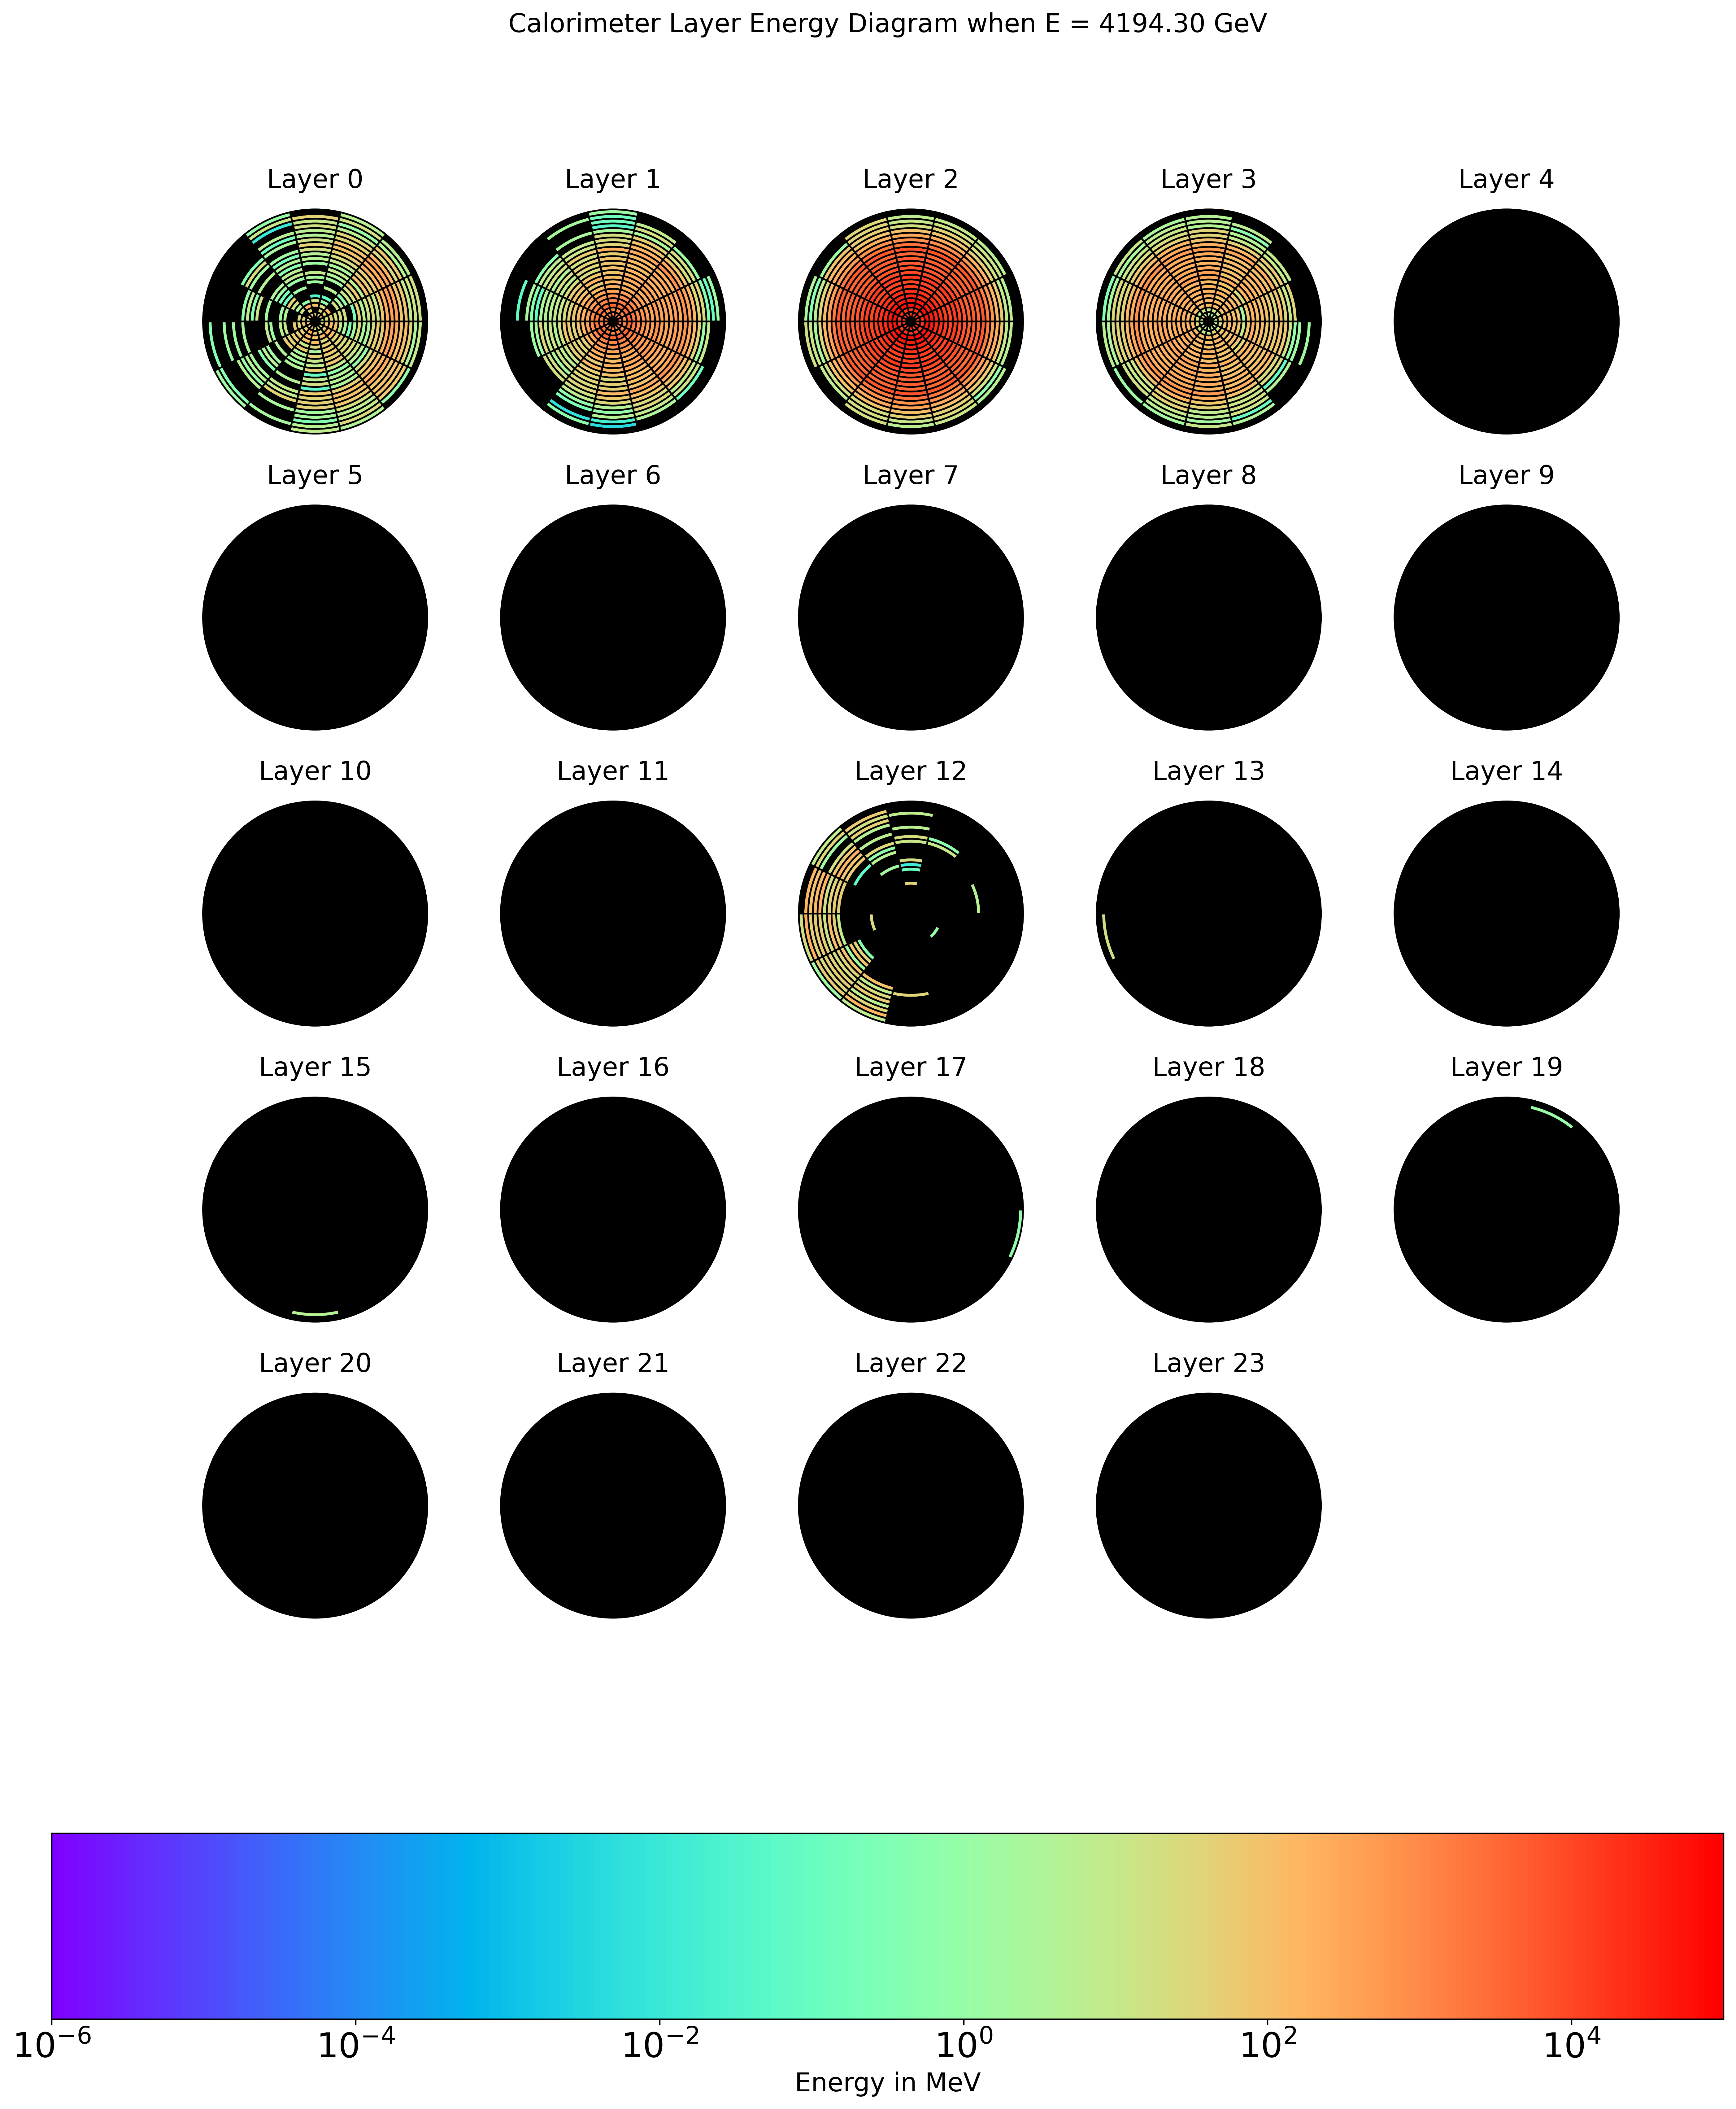

In [62]:
plot_atlas.plot_all_layers(124775,scale='equal_bin',vmin=0.000001, vmax=1e5)
# plot_atlas.plot_all_layers(10,scale='linear',vmin=1e-2, vmax=1e3)

/tmp/ipykernel_3364274/4237646877.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  incident_energy = torch.tensor(self.data["incident_energy"][self.event_n])


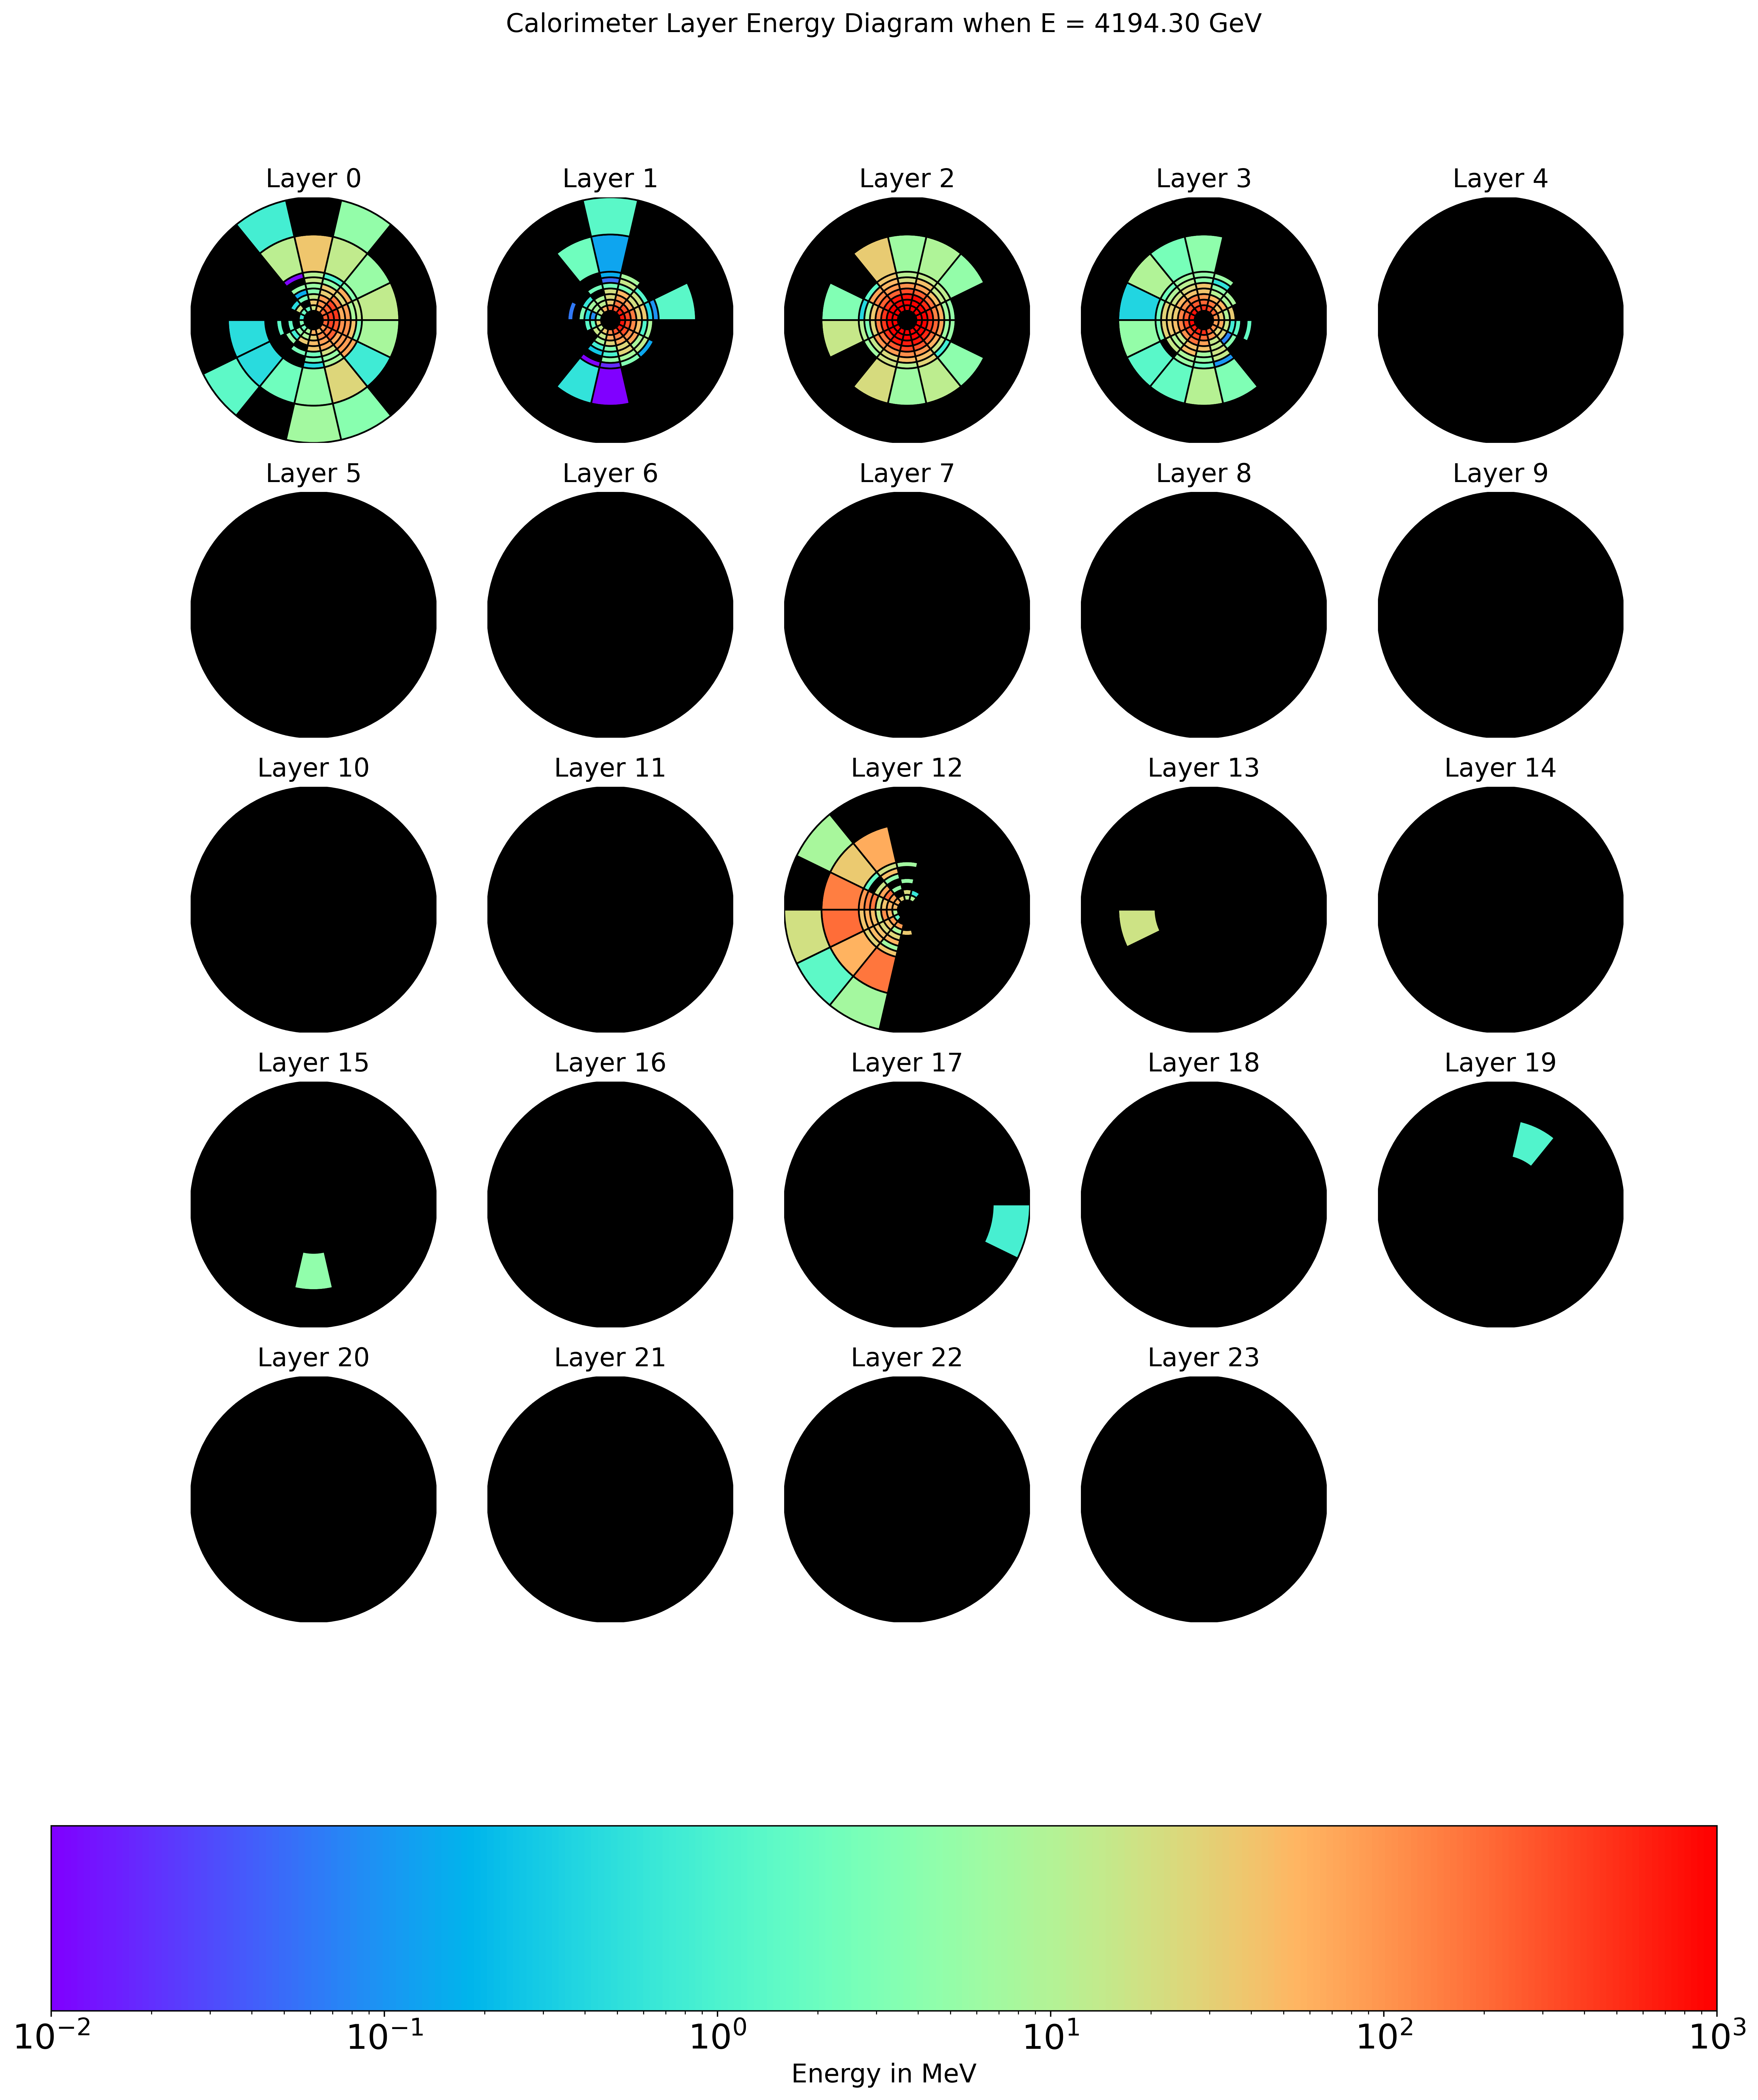

In [63]:
plot_atlas.plot_all_layers(124775,scale='linear',vmin=1e-2, vmax=1e3)

In [64]:
fn

'dataset_eta_095_positive.hdf5'

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

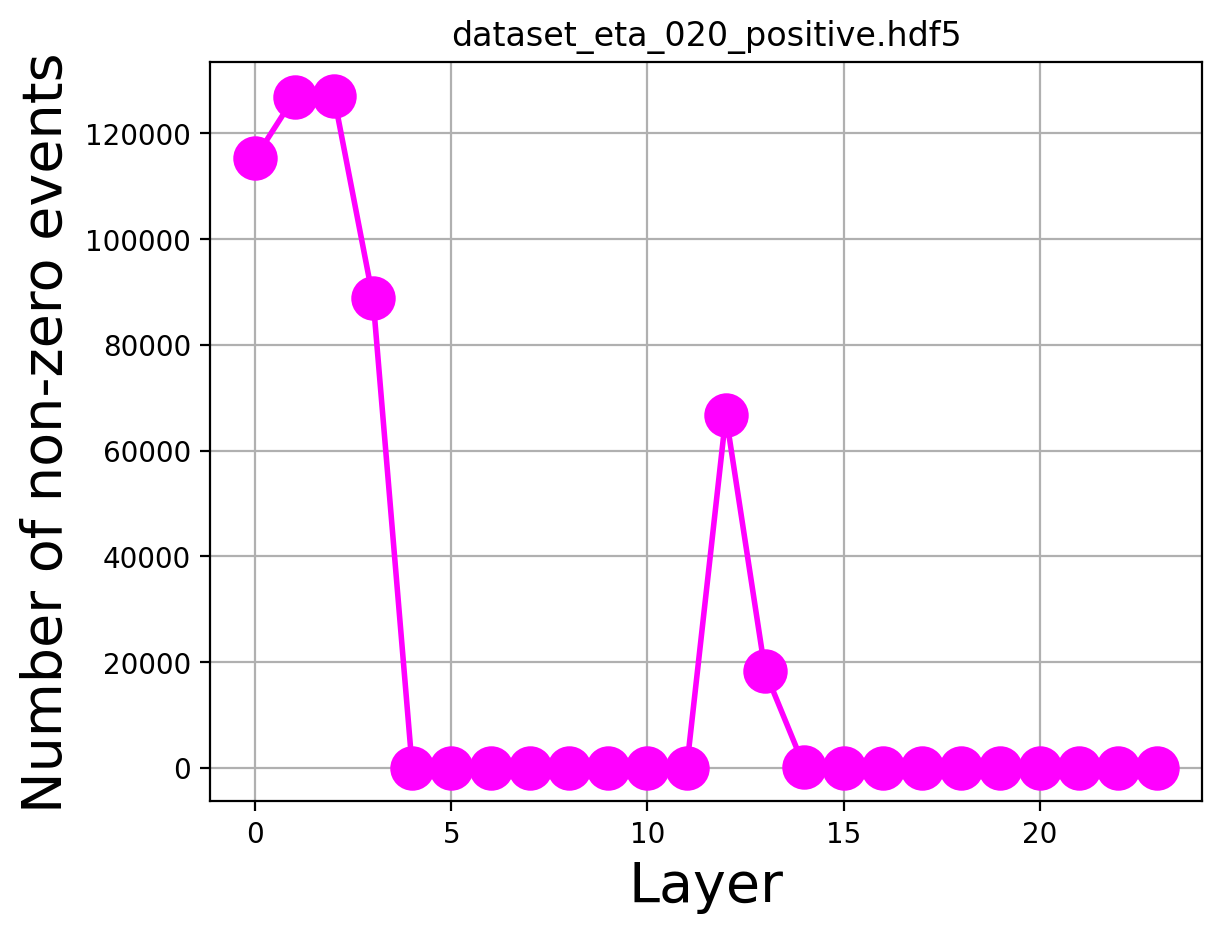

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

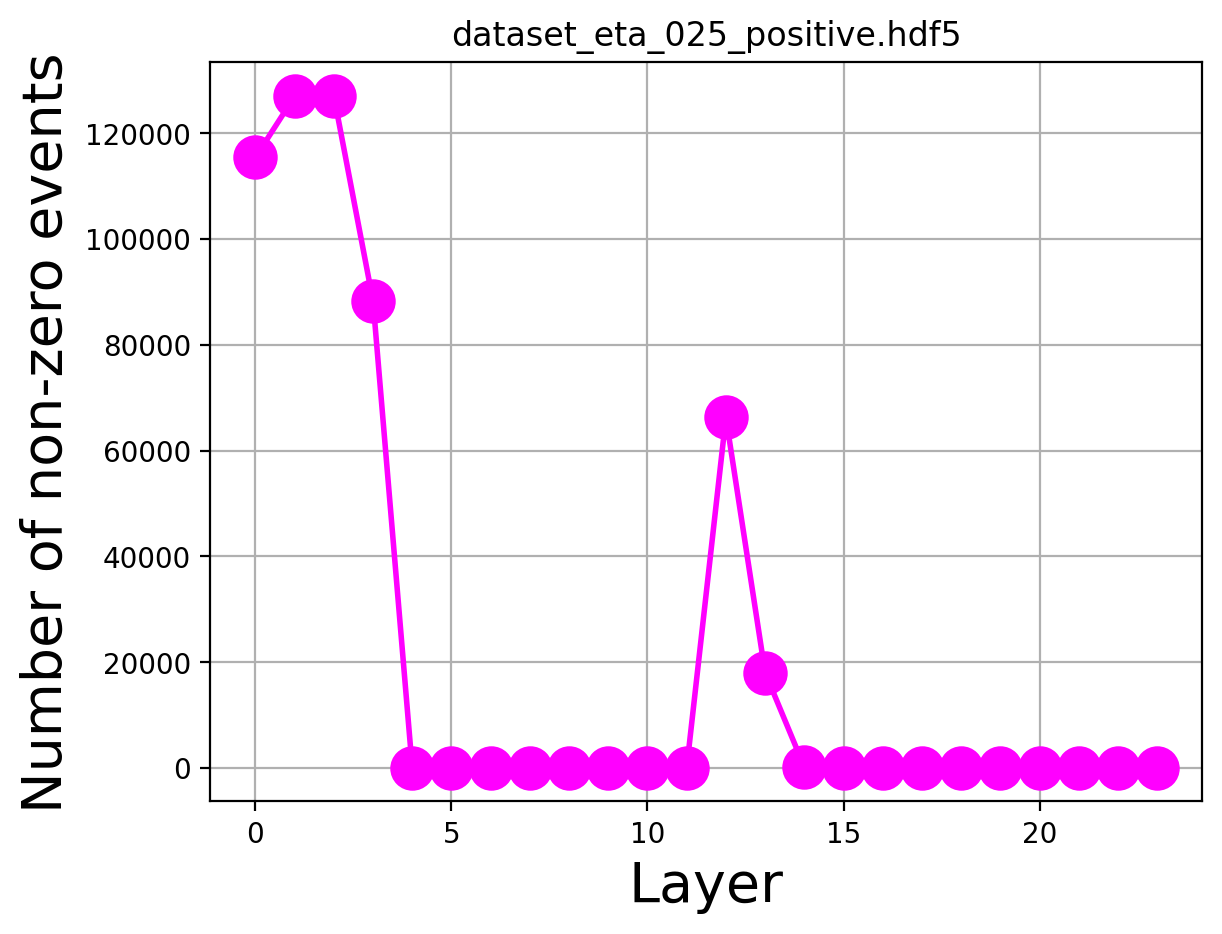

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

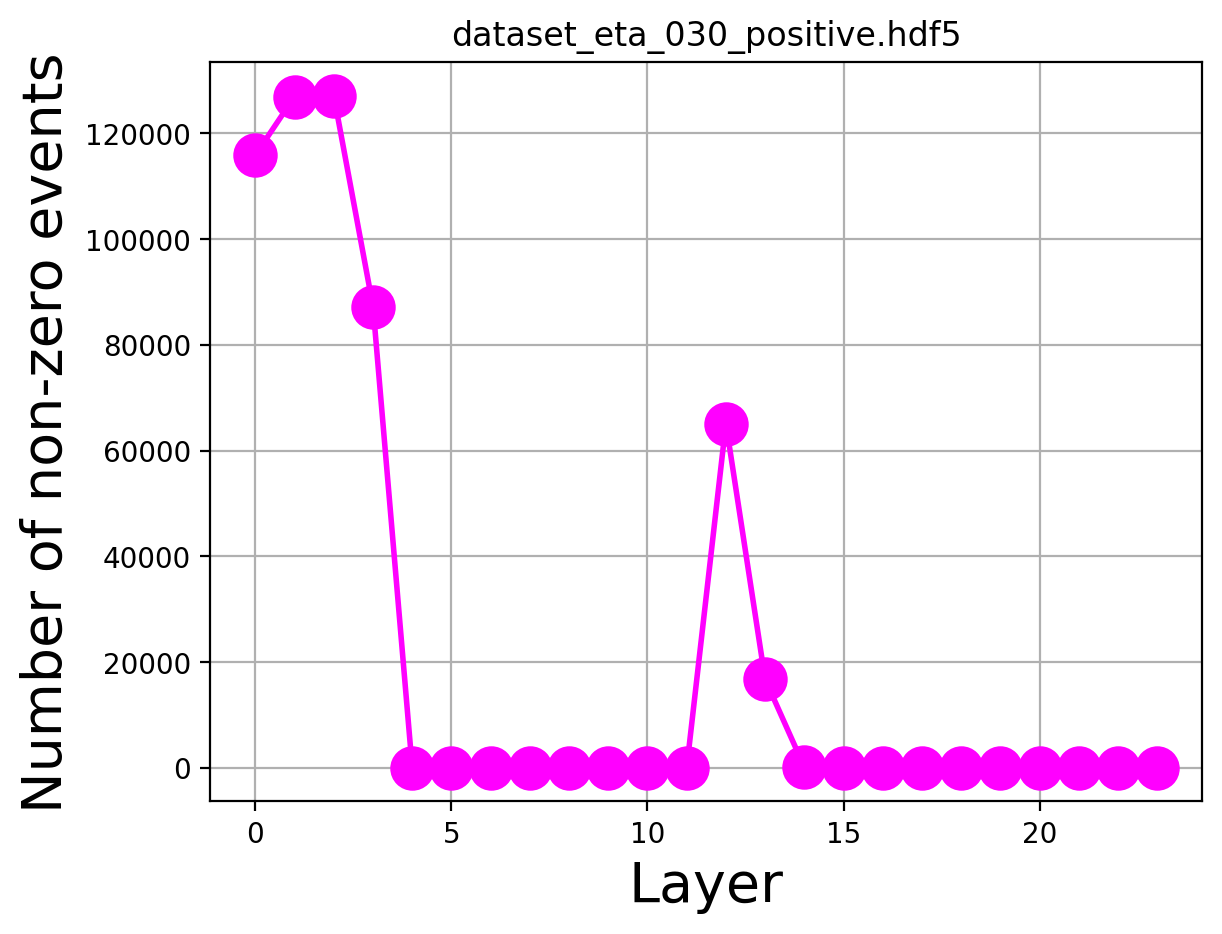

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

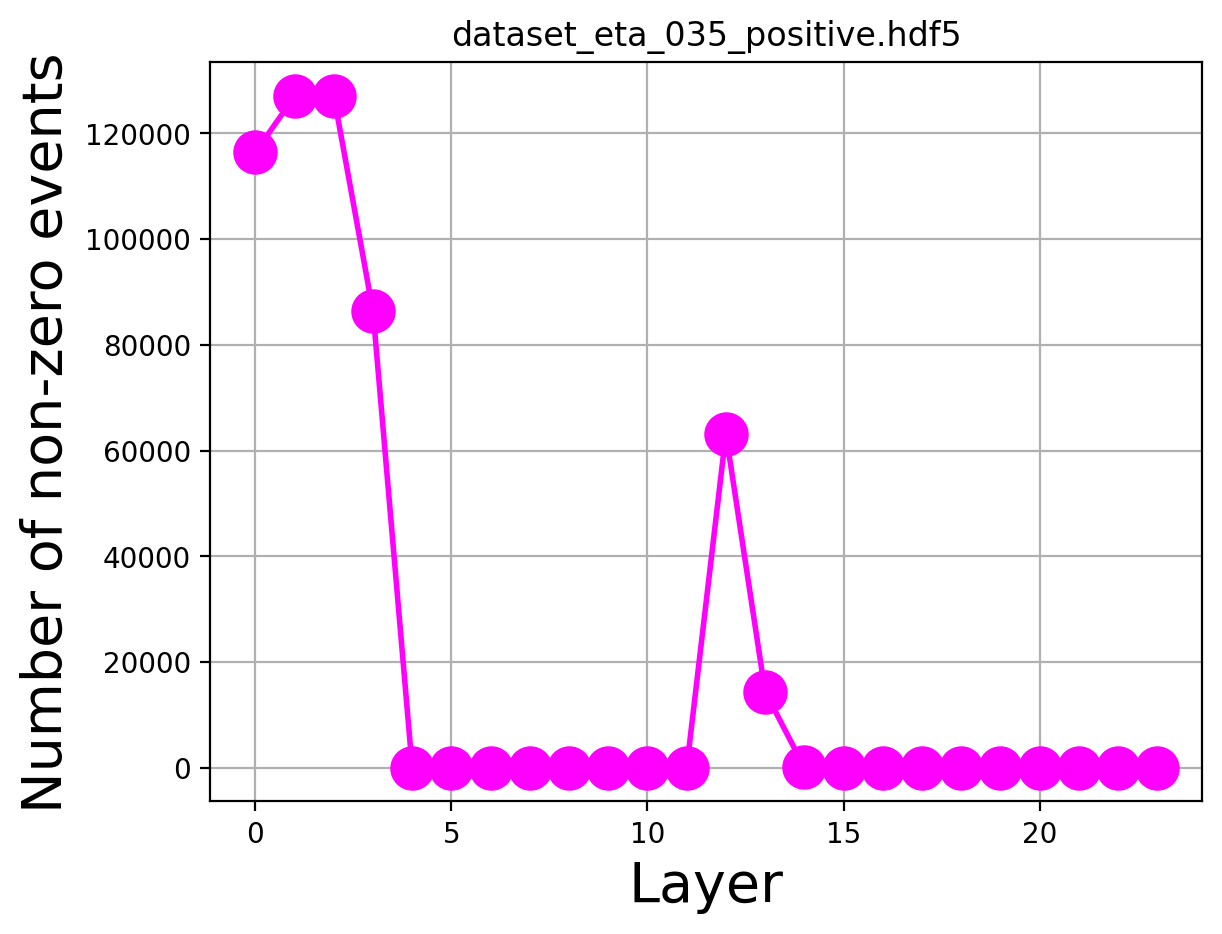

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

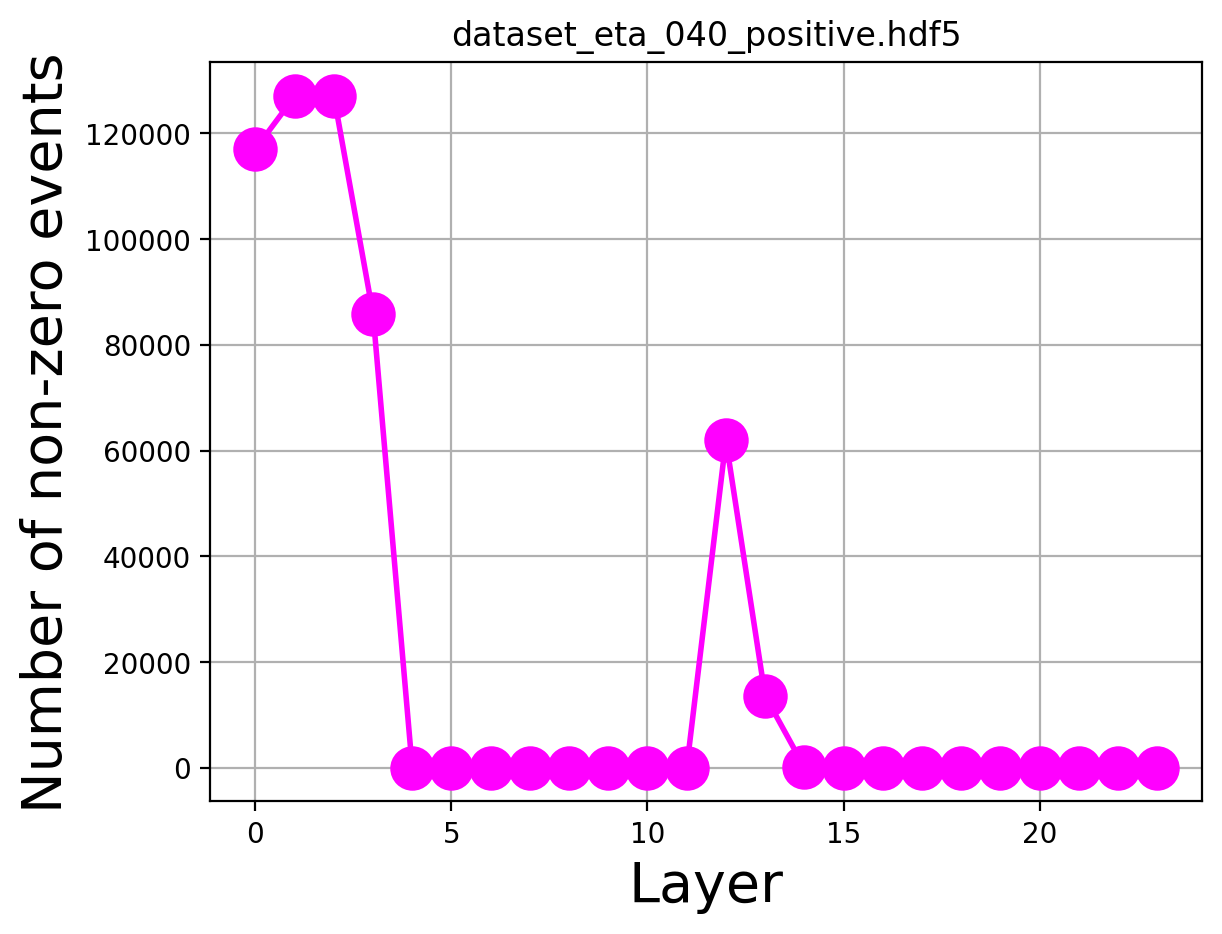

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

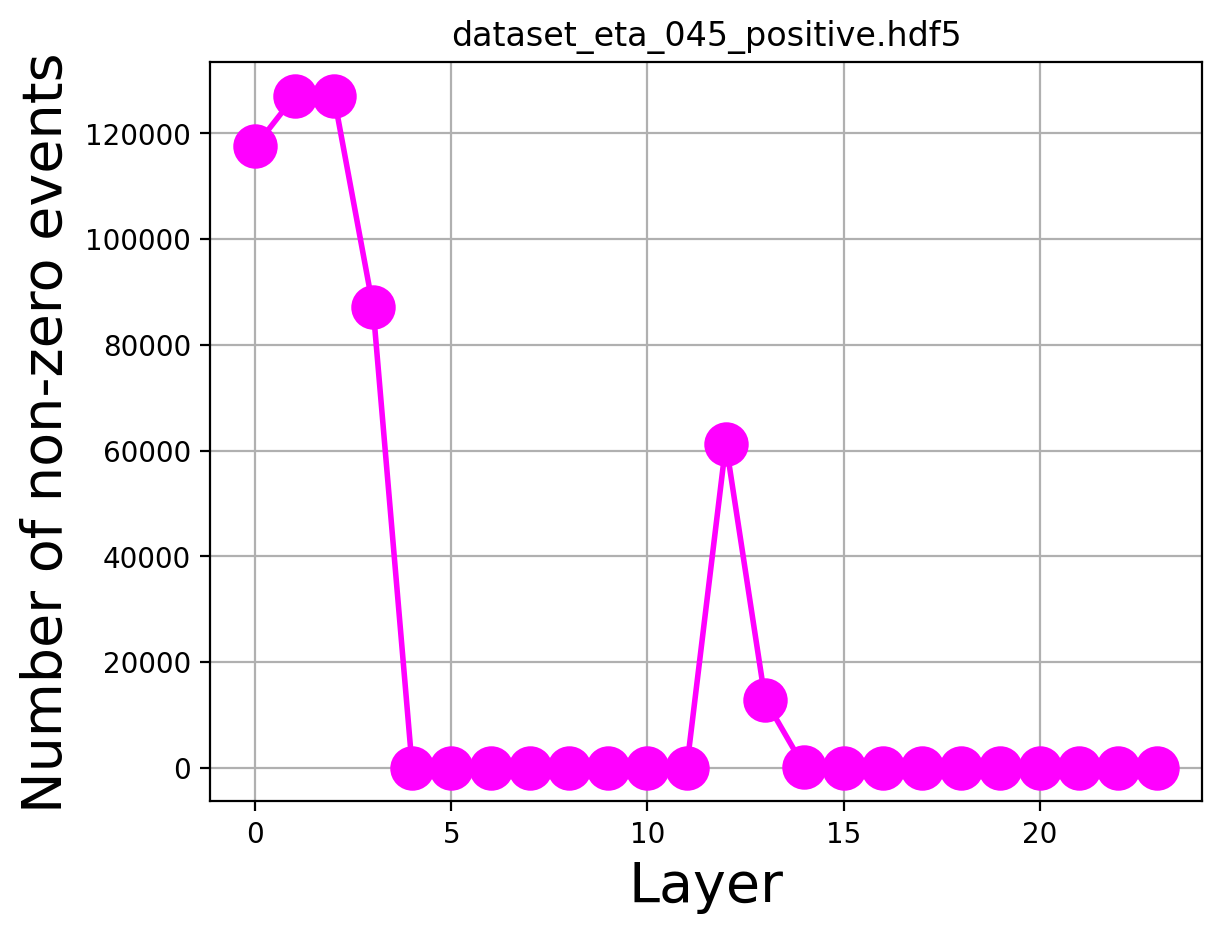

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

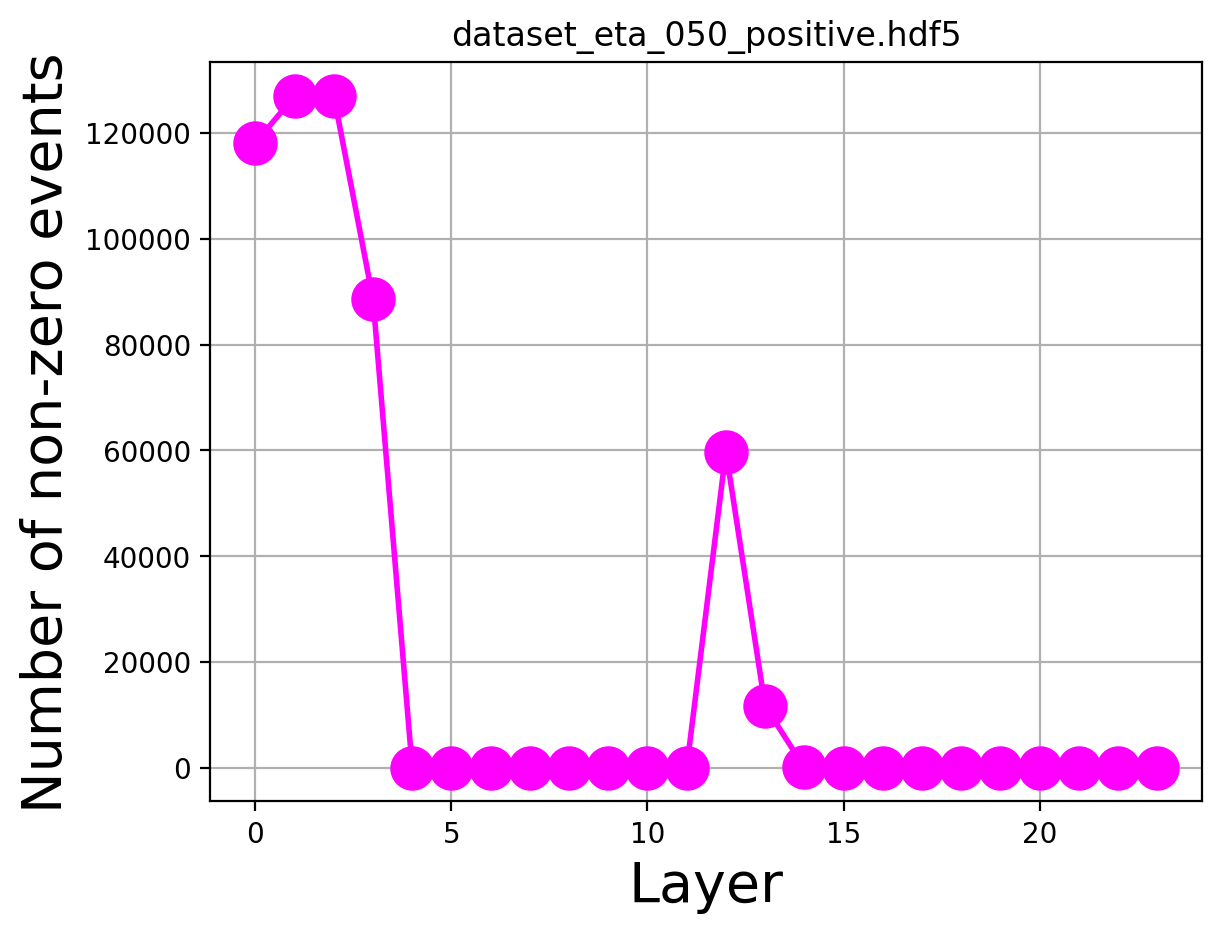

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

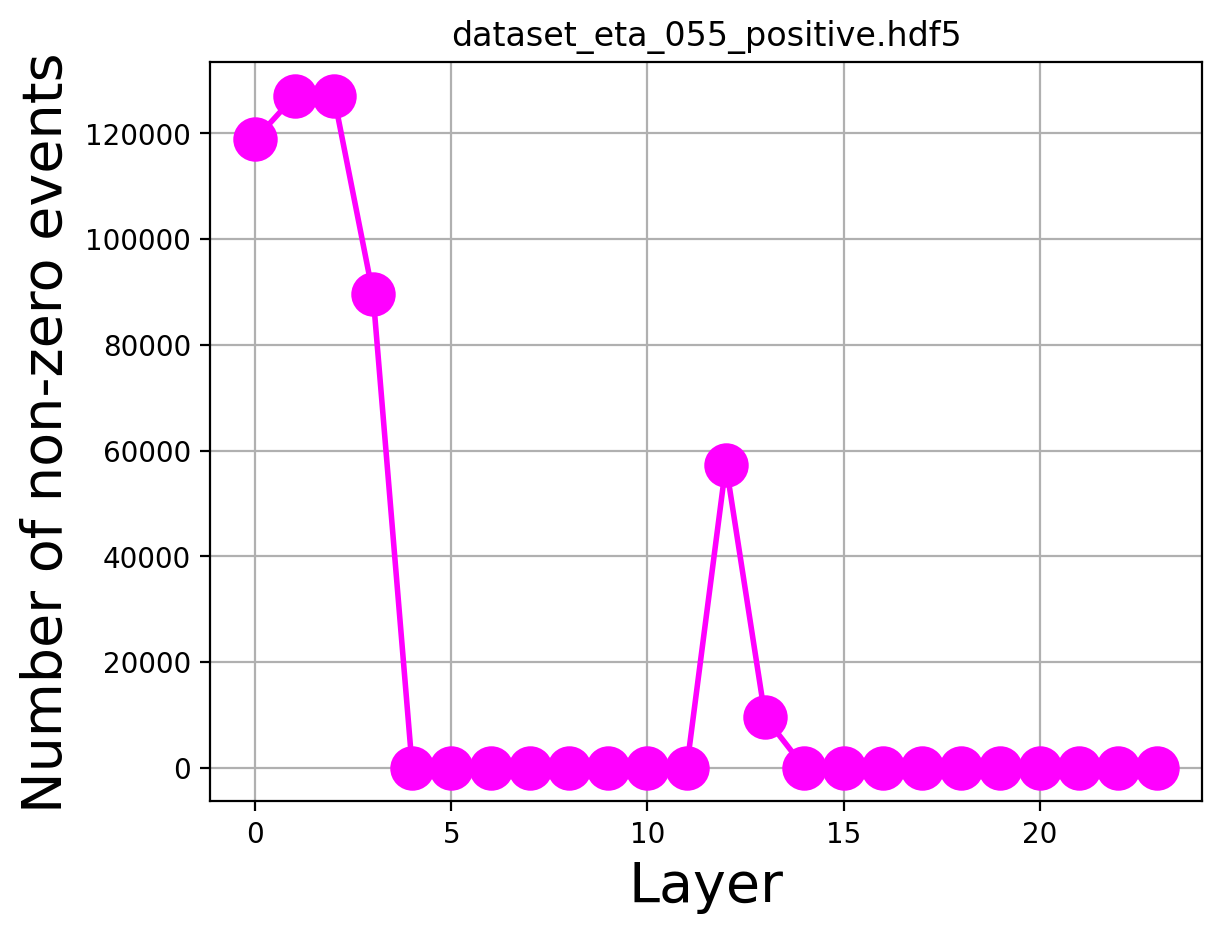

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

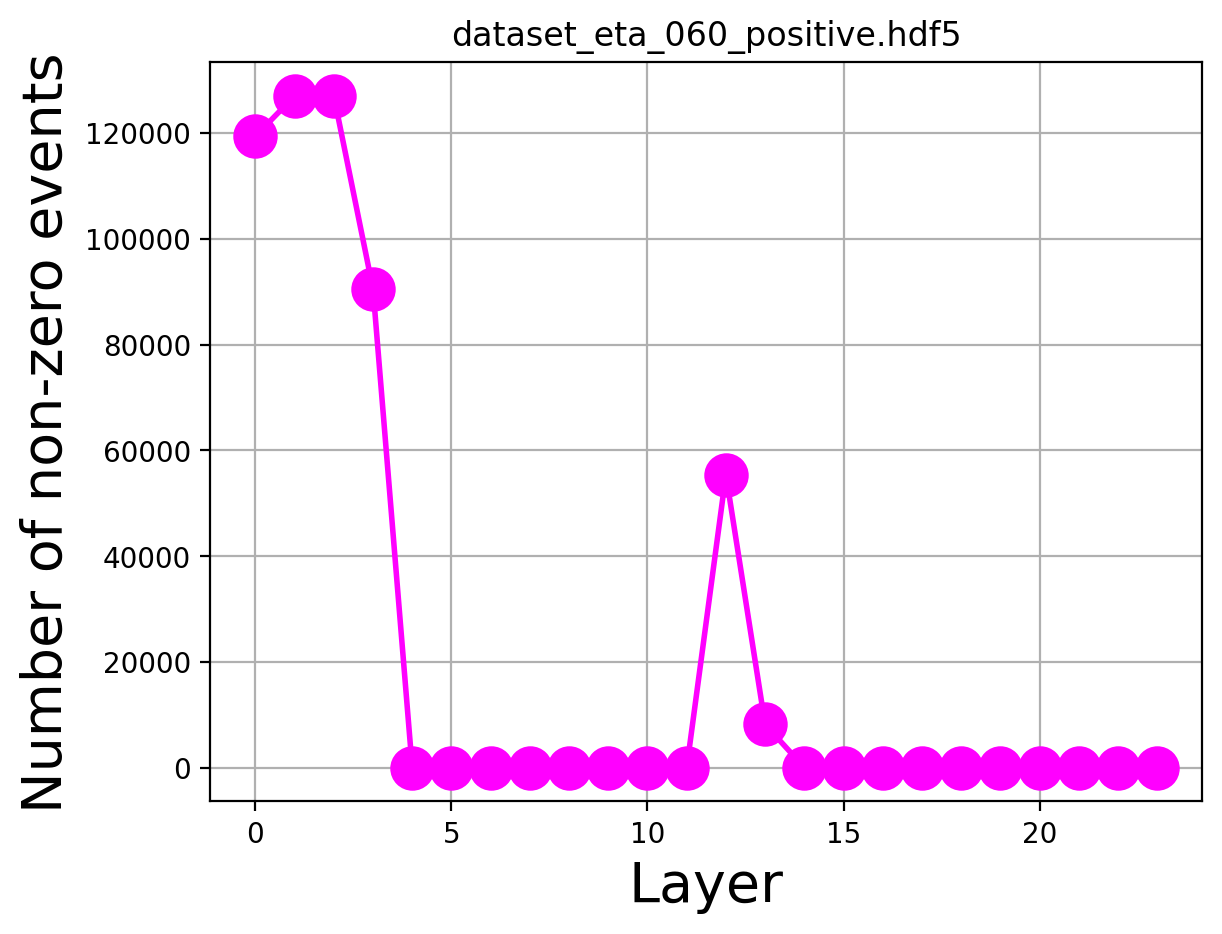

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

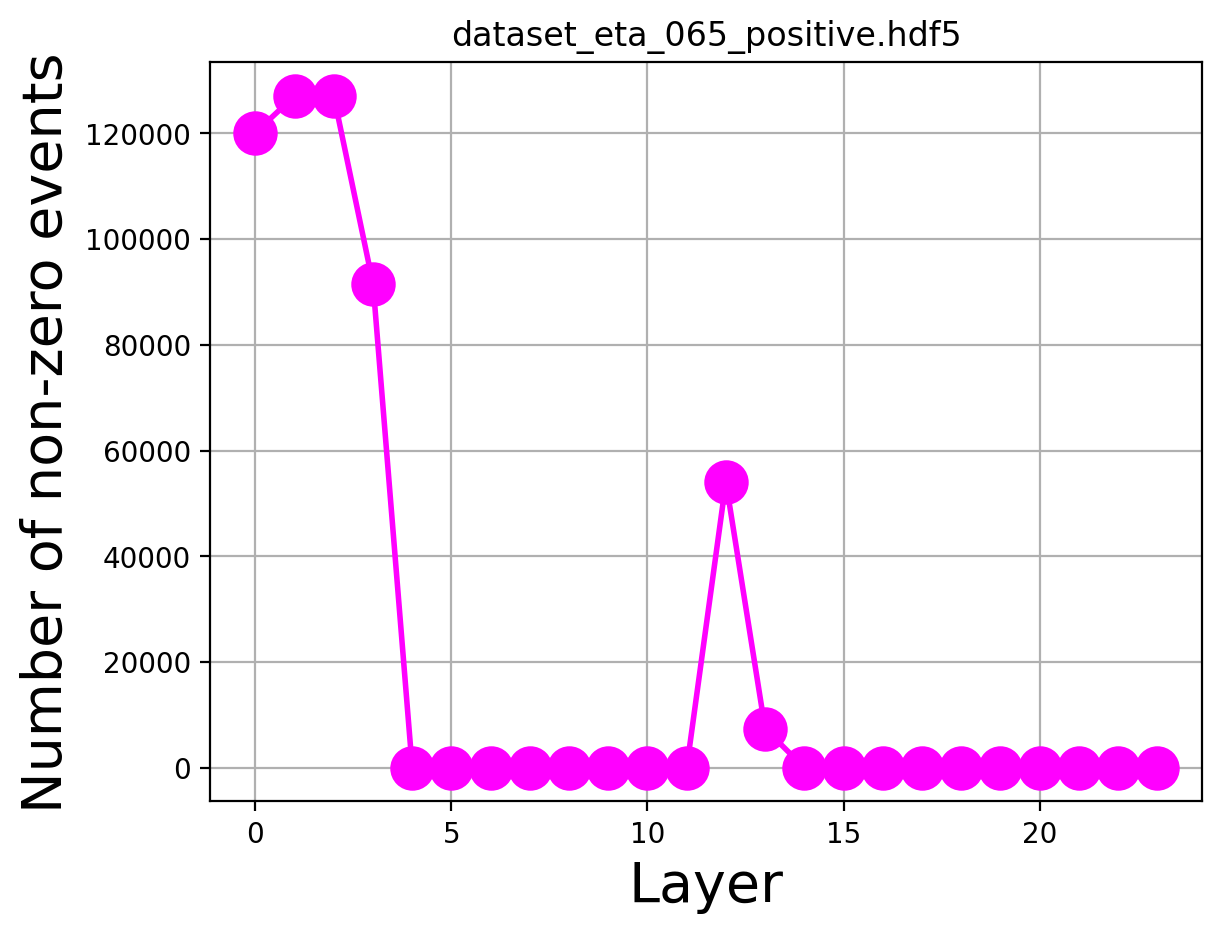

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

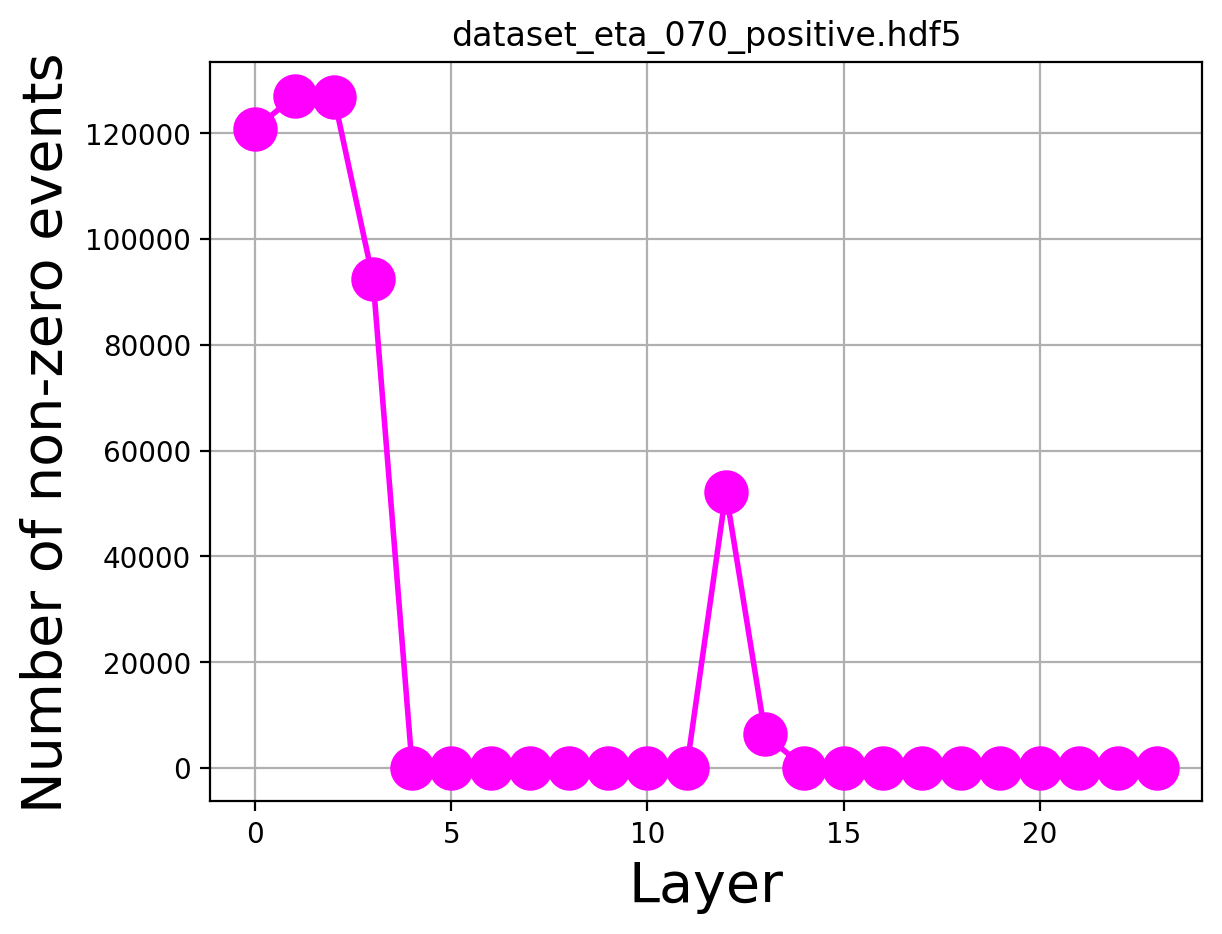

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

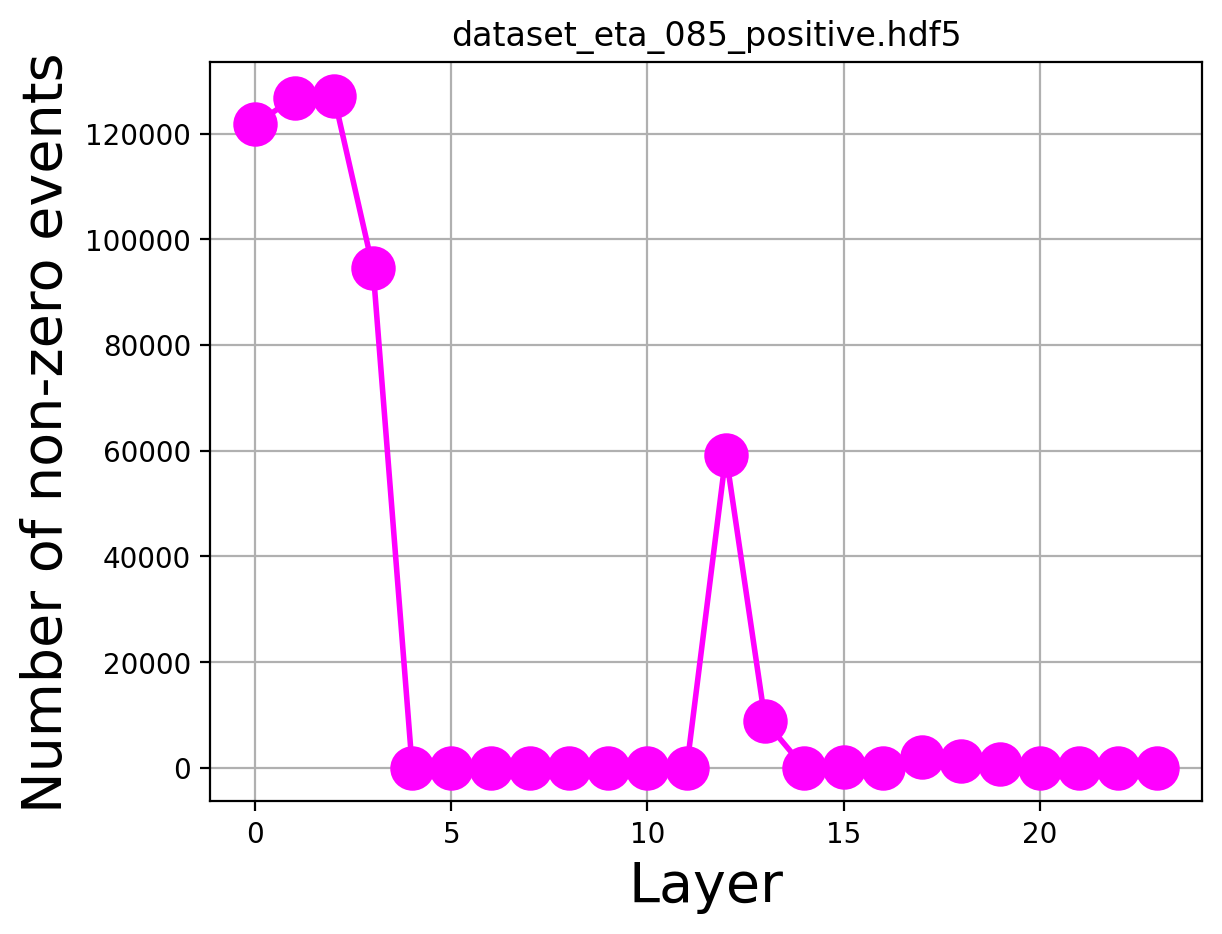

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

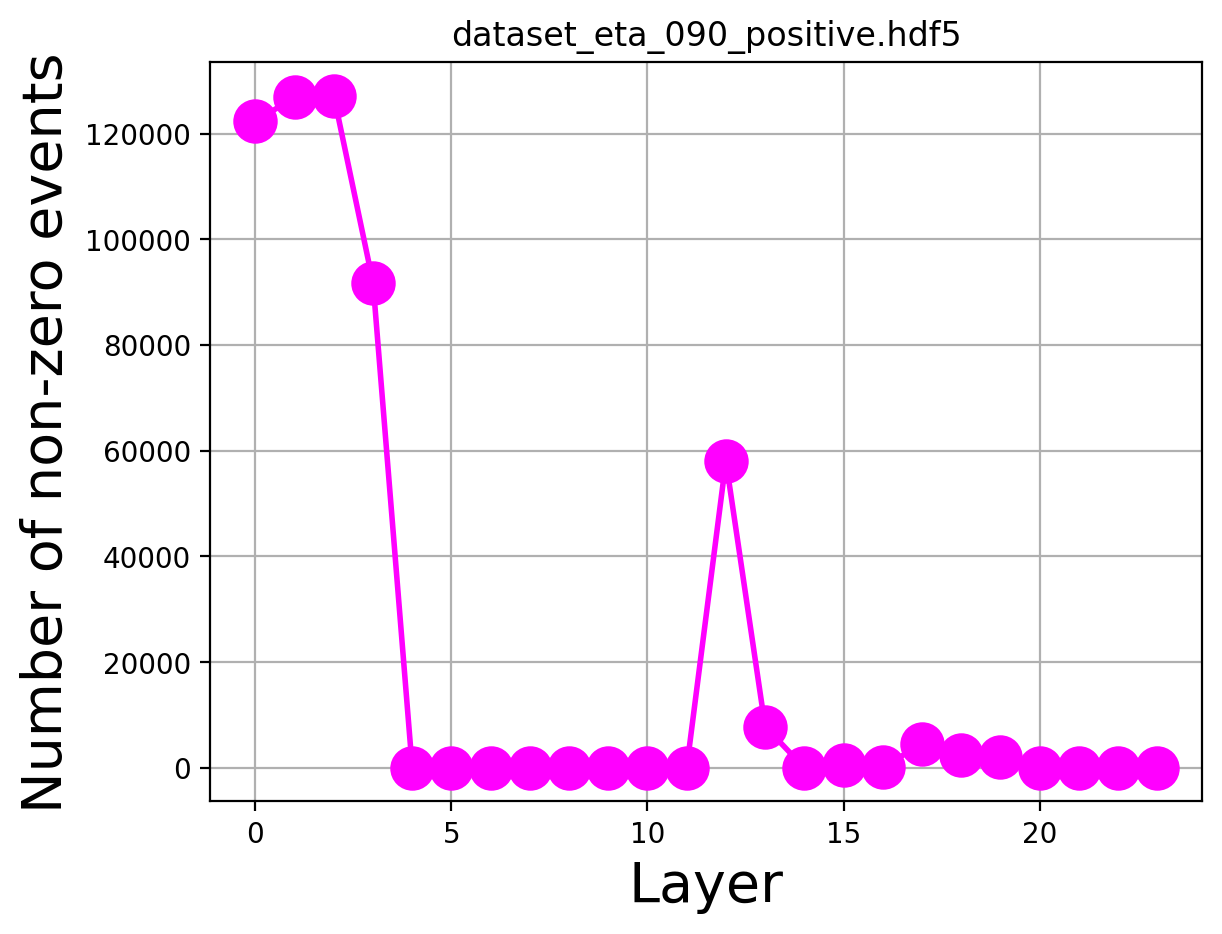

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

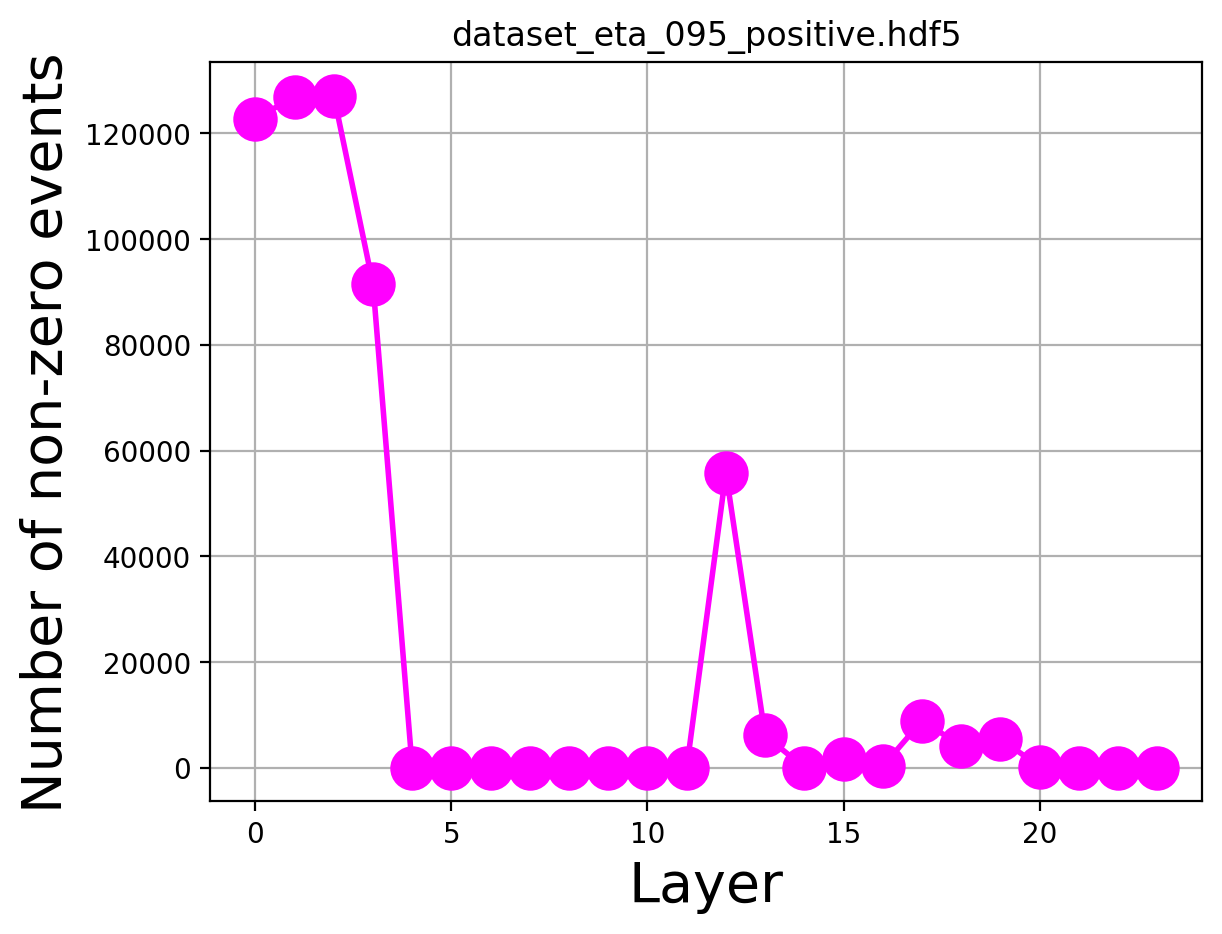

In [69]:
for fn in filenames:
    # print(fn)
    ATLAS_raw_dir = directory + fn #filenames[-2]
    plot_atlas = PLT_ATLAS(ATLAS_raw_dir,125000)
    plt.plot([plot_atlas.data[f'energy_layer_{i}'].sum(dim=1).nonzero().shape[0] for i in range(24)], lw=2, color="magenta", marker="o", markersize=15)
    plt.grid(True)
    plt.xlabel("Layer", fontsize=20)
    plt.ylabel("Number of non-zero events", fontsize=20)
    plt.title(f'{fn}')
    plt.show()




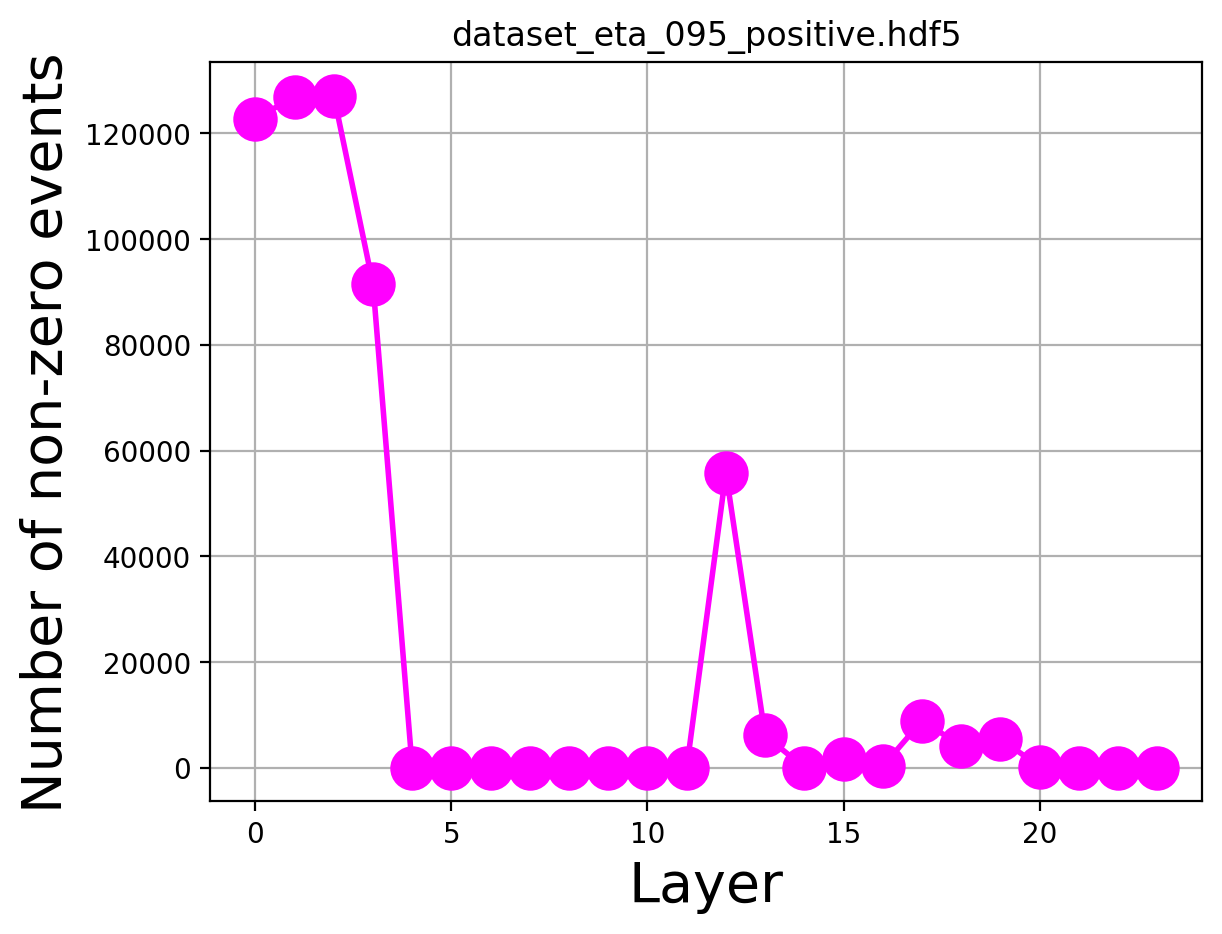

In [67]:
plt.plot([plot_atlas.data[f'energy_layer_{i}'].sum(dim=1).nonzero().shape[0] for i in range(24)], lw=2, color="magenta", marker="o", markersize=15)
plt.grid(True)
plt.xlabel("Layer", fontsize=20)
plt.ylabel("Number of non-zero events", fontsize=20)
plt.title(f'{fn}')
plt.show()

In [329]:
#############

In [330]:
atlas_fpath = "/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_2.hdf5"  #"/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_1.hdf5"  
atlas_=h5py.File(atlas_fpath,'r')

In [338]:
data_showers = torch.tensor(atlas_["showers"][:])
data_e = torch.tensor(atlas_["incident_energies"][:])

In [343]:
data_showers_perlayer = data_showers.reshape(-1,45,16,9).mean(dim=[2,3])

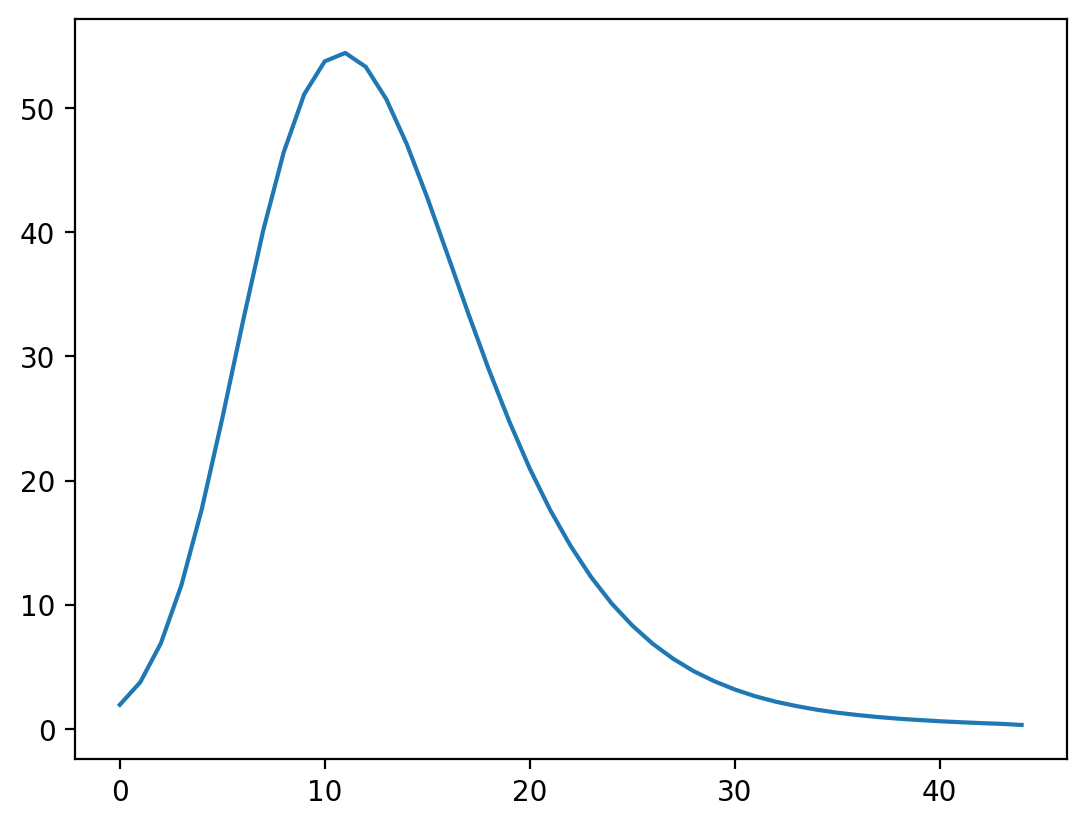

In [346]:
plt.plot(data_showers_perlayer.mean(dim=0))

(array([ 9829., 10014., 10018.,  9976.,  9987.,  9824., 10125., 10106.,
        10020., 10101.]),
 array([3.00031836, 3.30028345, 3.60024853, 3.90021362, 4.20017871,
        4.50014379, 4.80010888, 5.10007397, 5.40003906, 5.70000414,
        5.99996923]),
 <BarContainer object of 10 artists>)

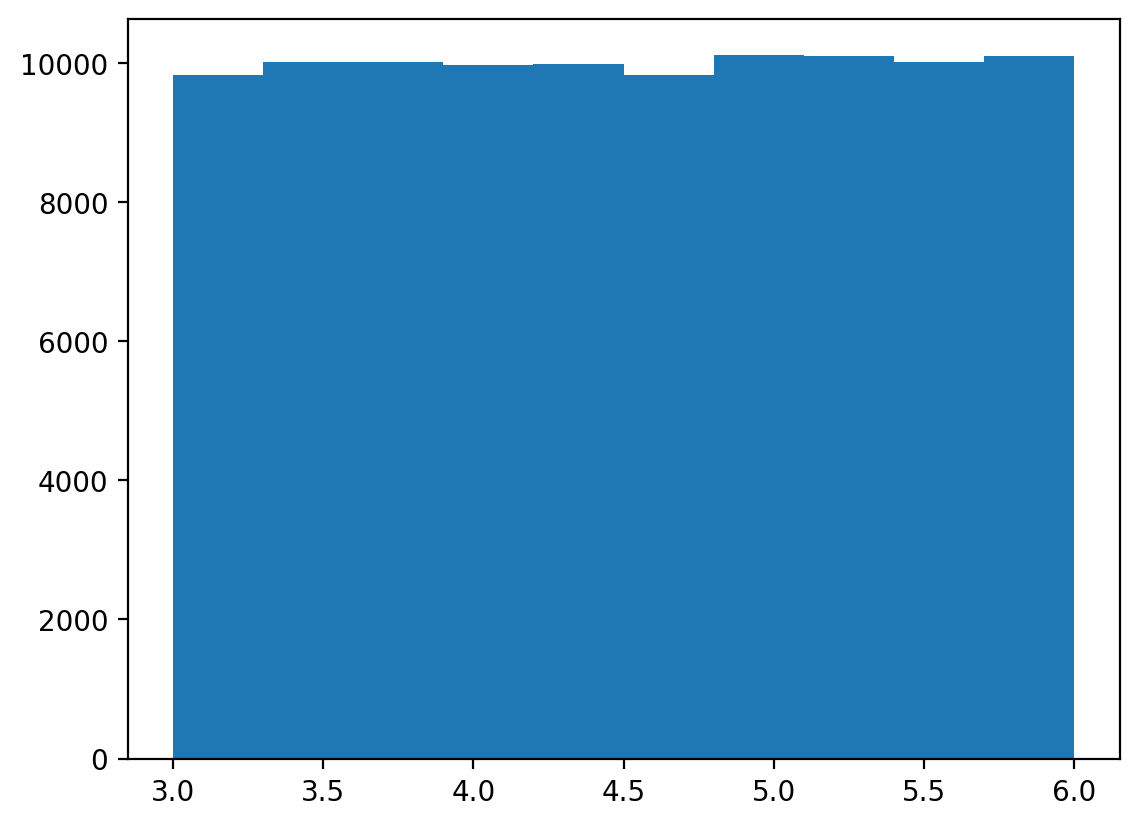

In [354]:
plt.hist(data_e.log10()[:,0])

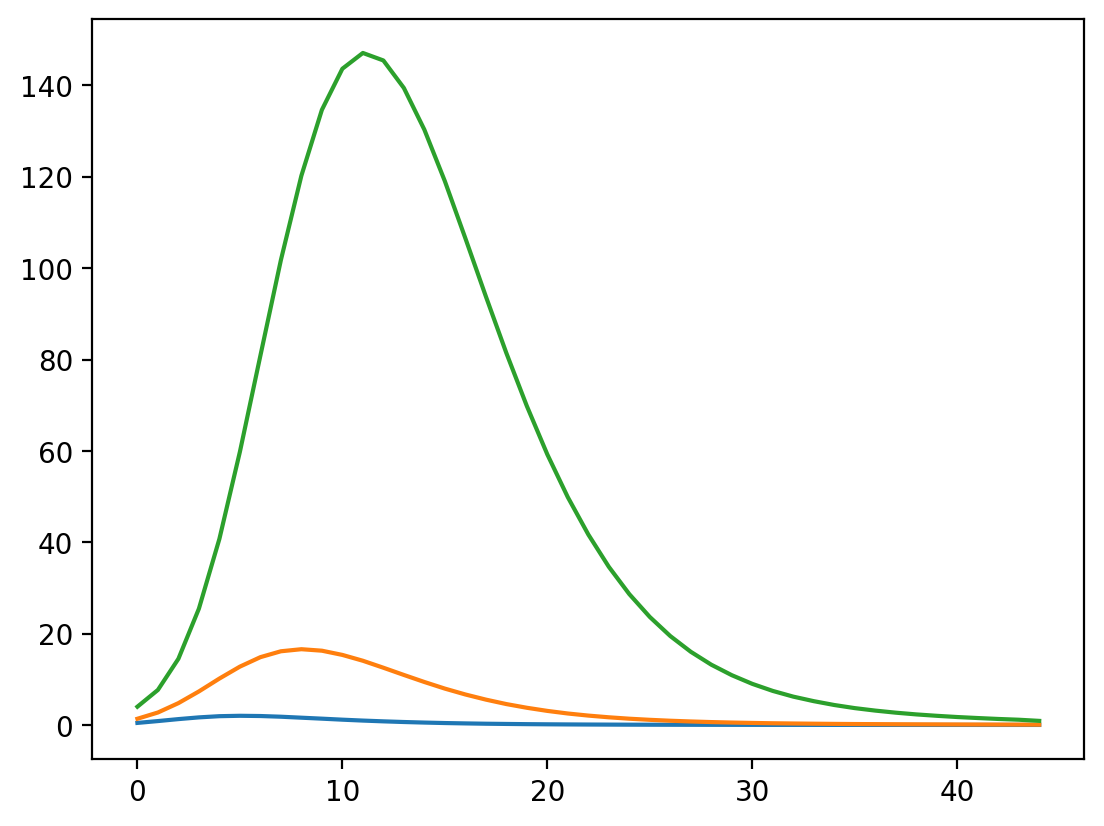

In [364]:
logEmin = 3
logEmax = 4
l = [3,4,5,6]
for i in range(len(l)-1):
    idx = (data_e.log10() < l[i+1]) * (data_e.log10() > l[i])
    data_e[idx].shape
    plt.plot(data_showers_perlayer[idx[:,0],:].mean(dim=0))
plt.show()

In [360]:
data_showers_perlayer.shape

torch.Size([100000, 45])

In [362]:
idx[:,0]

tensor([False, False, False,  ..., False, False, False])